In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve
from tqdm import tqdm
import pandas as pd
from scipy.stats import entropy
import copy
import math
from environments import SBEOS_Environment
time_dependence = 3
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transition tuple for experience replay
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'done', 'priority'))

class PrioritizedReplayBuffer:
    """Prioritized Experience Replay Buffer for important transitions"""
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=1e-6):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha  # How much prioritization to use (0 = no prioritization, 1 = full prioritization)
        self.beta = beta  # Correction factor for importance sampling
        self.beta_increment = beta_increment  # Beta increases over time for stable learning
        self.epsilon = epsilon  # Small constant to avoid zero probabilities
        self.max_priority = 1.0  # Initial priority for new transitions
        
    def push(self, *args):
        """Save a transition to the replay buffer with max priority"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        # Use max priority for new transitions (ensures they're sampled at least once)
        priority = self.max_priority ** self.alpha
        self.priorities[self.position] = priority
        
        # Store transition
        self.memory[self.position] = Transition(*args, priority=priority)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        """Sample a batch of transitions based on their priorities"""
        if len(self.memory) < self.capacity:
            probs = self.priorities[:len(self.memory)] / sum(self.priorities[:len(self.memory)])
        else:
            probs = self.priorities / sum(self.priorities)
            
        # Sample indices based on priorities
        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        
        # Calculate importance sampling weights
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize weights
        
        # Increment beta for next sampling
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Get transitions for the sampled indices
        transitions = [self.memory[idx] for idx in indices]
        
        # Return batch with additional metadata
        batch = Transition(*zip(*transitions))
        return batch, weights, indices
    
    def update_priorities(self, indices, priorities):
        """Update priorities based on TD errors"""
        for idx, priority in zip(indices, priorities):
            # Add small epsilon to avoid zero priority
            priority = (priority + self.epsilon) ** self.alpha
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.memory)

class NoisyLinear(nn.Module):
    """Noisy linear layer for exploration"""
    def __init__(self, in_features, out_features, std_init=0.1):
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        
        # Mean weights and biases
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))
        
        self.reset_parameters()
        self.reset_noise()
        
    def reset_parameters(self):
        """Initialize parameters"""
        mu_range = 1.0 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))
        
    def reset_noise(self):
        """Reset the noise for exploration"""
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        # Outer product
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)
        
    def _scale_noise(self, size):
        """Scale noise for factorized Gaussian noise"""
        noise = torch.randn(size, device=self.weight_mu.device)
        return torch.sign(noise) * torch.sqrt(torch.abs(noise))
        
    def forward(self, x):
        """Forward pass with noise"""
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
            
        return F.linear(x, weight, bias)

class EnhancedLSTMDQN(nn.Module):
    """Enhanced DQN that combines LSTM for temporal processing with NoisyNets for exploration"""
    def __init__(self, state_size, action_size, hidden_dim=128):
        super(EnhancedLSTMDQN, self).__init__()
        
        # Split state into window and statistical features
        self.window_size = state_size - 6  # Raw window part of state
        
        # LSTM for processing time series window data
        self.window_lstm = nn.LSTM(1, 32, batch_first=True)  # Process each window point individually
        
        # Linear layer for statistical features
        self.stats_layer = nn.Sequential(
            nn.Linear(6, 16),
            nn.LeakyReLU()
        )
        
        # Combined feature processing
        self.combined_layer = nn.Sequential(
            nn.Linear(32 + 16, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        # Noisy value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU()
        )
        self.value_noisy = NoisyLinear(hidden_dim // 2, 1)
        
        # Noisy advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU()
        )
        self.advantage_noisy = NoisyLinear(hidden_dim // 2, action_size)
        
    def forward(self, x, hidden=None):
        # Split input into raw window and statistical features
        batch_size = x.size(0)
        window = x[:, :self.window_size]
        stats = x[:, self.window_size:]
        
        # Reshape window for LSTM processing
        window = window.view(batch_size, self.window_size, 1)  # [batch, seq_len, 1]
        
        # Process window through LSTM
        window_out, lstm_hidden = self.window_lstm(window, hidden)
        window_features = window_out[:, -1, :]  # Take the last LSTM output
        
        # Process statistical features
        stats_features = self.stats_layer(stats)
        
        # Combine features
        combined = torch.cat([window_features, stats_features], dim=1)
        features = self.combined_layer(combined)
        
        # Dueling architecture with noisy layers
        value = self.value_stream(features)
        value = self.value_noisy(value)
        
        advantage = self.advantage_stream(features)
        advantage = self.advantage_noisy(advantage)
        
        # Combine value and advantage using dueling architecture formula
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        return q_values, lstm_hidden
    
    def reset_noise(self):
        """Reset noise for exploration"""
        self.value_noisy.reset_noise()
        self.advantage_noisy.reset_noise()

class EnhancedDQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        memory_size=100000,
        batch_size=128,
        gamma=0.99,
        tau=0.005,  # Soft update parameter
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,  # Steps for decay
        learning_rate=0.0003,
        target_update_freq=5,  # Update target every n episodes for hard updates
        double_dqn=True,
        prioritized_replay=True,  # Use prioritized experience replay
        n_step_return=3,  # Number of steps for n-step return
        use_soft_targets=True,  # Use soft target updates
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.double_dqn = double_dqn
        self.learning_rate = learning_rate
        self.n_step_return = n_step_return
        self.use_soft_targets = use_soft_targets
        self.steps_done = 0
        
        # For n-step returns
        self.n_step_buffer = deque(maxlen=n_step_return)
        
        # Initialize replay buffer
        if prioritized_replay:
            self.memory = PrioritizedReplayBuffer(memory_size)
            self.prioritized_replay = True
        else:
            self.memory = deque(maxlen=memory_size)
            self.prioritized_replay = False
        
        # Initialize LSTM-DQN networks with NoisyNets
        self.policy_net = EnhancedLSTMDQN(state_size, action_size).to(device)
        self.target_net = EnhancedLSTMDQN(state_size, action_size).to(device)
        self.hidden = None  # LSTM hidden state
            
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Learning rate scheduler for adaptive learning
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=10
        )
        
        # Training metrics
        self.rewards_history = []
        self.losses = []
        self.accuracies = []
        self.predictions = []
        self.true_states = []
        
        # Episode tracking for target updates
        self.episode_count = 0
        
    def select_action(self, state, evaluate=False, hidden=None):
        """Select an action using policy"""
        # Convert state to tensor
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).to(device)
            else:
                state_tensor = torch.FloatTensor([state]).to(device)
                
            # Make sure it has batch dimension
            if state_tensor.dim() == 1:
                state_tensor = state_tensor.unsqueeze(0)
            
            # Get Q-values
            q_values, new_hidden = self.policy_net(state_tensor, hidden)
            
            # Epsilon-greedy only needed as backup since we use NoisyNets
            if evaluate or random.random() > self.epsilon:
                return q_values.argmax(1).item(), new_hidden
            else:
                return random.randrange(self.action_size), new_hidden
    
    def update_epsilon(self):
        """Update epsilon using exponential decay (backup exploration)"""
        self.epsilon = self.epsilon_end + (self.epsilon - self.epsilon_end) * \
                       math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
    
    def remember(self, state, action, reward, next_state, done):
        """Store transition in replay memory with n-step returns"""
        # Store transition in the n-step buffer
        self.n_step_buffer.append((state, action, reward, next_state, done))
        
        # If the n-step buffer is full, compute n-step return
        if len(self.n_step_buffer) == self.n_step_return:
            state, action, n_reward, next_state, done = self.get_n_step_info()
            
            if self.prioritized_replay:
                # Initially use max priority for new experiences
                self.memory.push(state, action, next_state, n_reward, done)
            else:
                self.memory.append((state, action, next_state, n_reward, done))
    
    def get_n_step_info(self):
        """Get n-step transition info from n-step buffer"""
        # Get first transition from buffer
        state, action, reward, next_state, done = self.n_step_buffer[0]
        
        # Calculate cumulative reward with discount
        for idx in range(1, len(self.n_step_buffer)):
            r, next_s, d = self.n_step_buffer[idx][2:5]
            reward = reward + self.gamma ** idx * r
            
            # If transition is terminal, break
            if d:
                done = True
                next_state = next_s
                break
        
        return state, action, reward, next_state, done
    
    def replay(self):
        """Train the model with experiences from replay buffer"""
        if self.prioritized_replay and len(self.memory) < self.batch_size:
            return 0
        elif not self.prioritized_replay and len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        if self.prioritized_replay:
            transitions, weights, indices = self.memory.sample(self.batch_size)
            weights = torch.FloatTensor(weights).to(device)
            
            # Convert batch to tensors
            state_batch = torch.FloatTensor(np.array(transitions.state)).to(device)
            action_batch = torch.LongTensor(transitions.action).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(transitions.reward).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(np.array(transitions.next_state)).to(device)
            done_batch = torch.FloatTensor(transitions.done).unsqueeze(1).to(device)
        else:
            # Randomly sample from memory
            transitions = random.sample(self.memory, self.batch_size)
            state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*transitions)
            
            # Convert to tensors
            state_batch = torch.FloatTensor(np.array(state_batch)).to(device)
            action_batch = torch.LongTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(np.array(next_state_batch)).to(device)
            done_batch = torch.FloatTensor(done_batch).unsqueeze(1).to(device)
            weights = torch.ones_like(reward_batch)
        
        # Compute current Q values
        current_q_values, _ = self.policy_net(state_batch)
        current_q_values = current_q_values.gather(1, action_batch)
        
        # Compute next Q values based on algorithm choice
        with torch.no_grad():
            if self.double_dqn:
                # Double DQN: Use policy network to select actions
                next_q_values_policy, _ = self.policy_net(next_state_batch)
                next_actions = next_q_values_policy.max(1, keepdim=True)[1]
                
                next_q_values_target, _ = self.target_net(next_state_batch)
                next_q_values = next_q_values_target.gather(1, next_actions)
            else:
                # Standard DQN: Use max Q-value from target network
                next_q_values, _ = self.target_net(next_state_batch)
                next_q_values = next_q_values.max(1, keepdim=True)[0]
            
            # Compute expected Q values
            expected_q_values = reward_batch + self.gamma**self.n_step_return * next_q_values * (1 - done_batch)
        
        # Compute loss (Huber loss for stability)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values, reduction='none')
        
        # Apply importance sampling weights for prioritized replay
        weighted_loss = (loss * weights).mean()
        
        # Compute TD errors for updating priorities
        if self.prioritized_replay:
            with torch.no_grad():
                td_errors = torch.abs(current_q_values - expected_q_values).cpu().numpy()
                self.memory.update_priorities(indices, td_errors)
        
        # Optimize the model
        self.optimizer.zero_grad()
        weighted_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Reset noise for NoisyNets
        self.policy_net.reset_noise()
        
        return weighted_loss.item()
    
    def update_target_network(self):
        """Update target network weights"""
        # Increment episode counter
        self.episode_count += 1
        
        if self.use_soft_targets:
            # Soft update
            for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)
        elif self.episode_count % self.target_update_freq == 0:
            # Hard update
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def save_model(self, filepath):
        """Save model weights"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done
        }, filepath)
        
    def load_model(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']
        self.target_net.eval()


# 1. First, let's correct the evaluate_episode function to maintain backward compatibility
def evaluate_episode(env, agent):
    """Evaluate the agent on a single episode without exploration"""
    state = env.reset()
    done = False
    total_reward = 0
    total_energy = 0
    hidden = None
    
    while not done:
        # Select action without exploration
        action, hidden = agent.select_action(state, evaluate=True, hidden=hidden)
        
        # Execute action
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        # Track energy consumption if available
        if "energy_consumed" in info:
            total_energy += info["energy_consumed"]
        
        # Update state
        state = next_state
    
    # Return reward for backward compatibility, as well as energy as a second value
    return total_reward

# 2. For the new version with energy tracking, we'll create a separate function
def evaluate_episode_with_energy(env, agent):
    """Evaluate the agent on a single episode without exploration, tracking energy"""
    state = env.reset()
    done = False
    total_reward = 0
    total_energy = 0
    hidden = None
    
    while not done:
        # Select action without exploration
        action, hidden = agent.select_action(state, evaluate=True, hidden=hidden)
        
        # Execute action
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        # Track energy consumption if available
        if "energy_consumed" in info:
            total_energy += info["energy_consumed"]
        
        # Update state
        state = next_state
    
    return total_reward, total_energy

# 3. Update the training function to work with both versions
def train_enhanced_dqn(env, agent, episodes=500, eval_freq=10, track_energy=False):
    """Train the enhanced DQN agent"""
    # Record best model for early stopping
    best_reward = float('-inf')
    best_model = None
    no_improvement_count = 0
    
    # Training metrics
    episode_rewards = []
    all_predictions = []
    all_true_states = []
    training_losses = []
    
    # Add energy consumption tracking
    episode_energy = []
    cumulative_energy = []
    total_energy = 0
    
    # Episode window for tracking improvement
    window_size = 10
    window_rewards = deque(maxlen=window_size)
    
    # Training loop
    for episode in tqdm(range(episodes), desc="Training Enhanced LSTM-DQN"):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        steps = 0
        done = False
        
        # Track energy consumption for this episode
        episode_energy_consumption = 0
        
        # Clear LSTM hidden state at episode start
        agent.hidden = None
        
        # Episode experience collection
        episode_predictions = []
        episode_true_states = []
        
        while not done:
            # Select action
            action, agent.hidden = agent.select_action(state, hidden=agent.hidden)
            
            # Execute action
            next_state, reward, done, info = env.step(action)
            
            # Track energy consumption (assuming it's available in info)
            if track_energy and "energy_cost" in info:
                energy_consumed = info["energy_cost"]
                episode_energy_consumption += energy_consumed
            
            # Record prediction and true state
            if "state" in info:
                episode_predictions.append(action%2)
                episode_true_states.append(info["state"])
            
            # Remember in replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Update state
            state = next_state
                
            episode_reward += reward*2 if action<2 else reward
            steps += 1
            
            # Train the network more frequently for faster learning
            if steps % 4 == 0:
                loss = agent.replay()
                if loss is not None:
                    episode_loss += loss
            
            # Update epsilon for backup exploration
            agent.update_epsilon()
        
        # Additional training at end of episode (multiple updates)
        for _ in range(4):
            loss = agent.replay()
            if loss is not None:
                episode_loss += loss
        
        # Update target network
        agent.update_target_network()
        
        # Record episode metrics
        avg_loss = episode_loss / max(1, steps // 4)
        episode_rewards.append(episode_reward)
        if episode_predictions:  # Only extend if we have predictions
            all_predictions.extend(episode_predictions)
            all_true_states.extend(episode_true_states)
        training_losses.append(avg_loss)
        window_rewards.append(episode_reward)
        
        # Record energy consumption if tracking
        if track_energy:
            episode_energy.append(episode_energy_consumption)
            total_energy = episode_energy_consumption
            cumulative_energy.append(total_energy)
        
        # Calculate accuracy for the episode if we have predictions
        episode_accuracy = 0
        if episode_predictions:
            episode_accuracy = np.mean(np.array(episode_predictions) == np.array(episode_true_states))
        
        # Print progress
        if (episode + 1) % 10 == 0:
            window_avg = np.mean(window_rewards)
            progress_msg = f"Episode: {episode+1}, Reward: {episode_reward:.2f}, Avg Reward (last {window_size}): {window_avg:.2f}, "
            progress_msg += f"Accuracy: {episode_accuracy:.4f}, Loss: {avg_loss:.6f}, Epsilon: {agent.epsilon:.4f}"
            
            if track_energy:
                progress_msg += f", Energy: {episode_energy_consumption:.2f}"
                
            print(progress_msg)
            
            # Update learning rate based on performance
            agent.scheduler.step(window_avg)
        
        # Save best model
        if len(window_rewards) == window_size:
            window_avg = np.mean(window_rewards)
            if window_avg > best_reward:
                best_reward = window_avg
                best_model = copy.deepcopy(agent.policy_net.state_dict())
                no_improvement_count = 0
                print(f"New best model saved! Avg reward: {best_reward:.2f}")
            else:
                no_improvement_count += 1
        
        # Early stopping if no improvement for a while
        if no_improvement_count >= 30:
            print(f"Early stopping after {episode+1} episodes - no improvement for 30 episodes")
            if best_model is not None:
                agent.policy_net.load_state_dict(best_model)
            break
                
        # Evaluate agent periodically
        if (episode + 1) % eval_freq == 0:
            eval_reward = evaluate_episode(env, agent)
            print(f"Evaluation at episode {episode+1}: Reward = {eval_reward:.2f}")
            
    # Update agent metrics
    agent.rewards_history = episode_rewards
    agent.losses = training_losses
    agent.predictions = all_predictions
    agent.true_states = all_true_states
    
    # Add energy metrics to agent if tracked
    if track_energy:
        agent.episode_energy = episode_energy
        agent.cumulative_energy = cumulative_energy
    
    # If training completed without early stopping, load best model
    if best_model is not None and episode == episodes - 1:
        agent.policy_net.load_state_dict(best_model)
        
    # Calculate final accuracy if we have predictions
    final_accuracy = 0
    if all_predictions:
        final_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
        print(f"Training completed. Final accuracy: {final_accuracy:.4f}")
    
    # Return appropriate values based on energy tracking
    if track_energy:
        return agent, episode_rewards, training_losses, episode_energy, cumulative_energy
    else:
        return agent, episode_rewards, training_losses

# 4. Finally, update the run_experiment function to use the track_energy parameter
def run_experiment(seed=42, episodes=300, track_energy=False):
    """Run a complete experiment with the SBEOS environment and enhanced DQN agent"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create environment
    env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = 2  # Binary prediction: 0 or 1
    
    # Create agent with enhanced features
    agent = EnhancedDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=50000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,
        learning_rate=0.0003,
        target_update_freq=5,
        double_dqn=True,
        prioritized_replay=True,
        n_step_return=3,
        use_soft_targets=True
    )
    
    # Train agent with or without energy tracking
    if track_energy:
        trained_agent, rewards, losses, episode_energy, cumulative_energy = train_enhanced_dqn(
            env, agent, episodes=episodes, eval_freq=20, track_energy=True
        )
    else:
        trained_agent, rewards, losses = train_enhanced_dqn(
            env, agent, episodes=episodes, eval_freq=20, track_energy=False
        )
    
    # Plot results
    if track_energy:
        plot_training_results(
            rewards, 
            losses,
            episode_energy,
            cumulative_energy,
            predictions=trained_agent.predictions, 
            true_states=trained_agent.true_states
        )
    else:
        plot_training_results(
            rewards, 
            losses,
            predictions=trained_agent.predictions, 
            true_states=trained_agent.true_states
        )
    
    # Evaluate final performance
    eval_rewards = []
    eval_energy = [] if track_energy else None
    
    for _ in range(20):  # Run 20 evaluation episodes
        if track_energy:
            reward, energy = evaluate_episode_with_energy(env, trained_agent)
            eval_rewards.append(reward)
            eval_energy.append(energy)
        else:
            reward = evaluate_episode(env, trained_agent)
            eval_rewards.append(reward)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    
    if track_energy:
        avg_energy = np.mean(eval_energy)
        print(f"Final evaluation - Average energy consumption over 20 episodes: {avg_energy:.2f}")
    
    # Save the trained model
    trained_agent.save_model("enhanced_lstm_dqn_model.pt")
    
    return trained_agent






def plot_training_results(rewards, losses, episode_energy=None, cumulative_energy=None, predictions=None, true_states=None):
    """Plot training metrics and model performance including energy consumption"""
    # Create figure with appropriate layout
    if episode_energy is not None:
        fig, axs = plt.subplots(3, 2, figsize=(18, 15))
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(2, 2, figsize=(18, 10))
        axs = axs.flatten()
    
    # Plot rewards
    axs[0].plot(rewards, label='Episode Reward')
    axs[0].plot(pd.Series(rewards).rolling(10).mean(), 'r-', label='Moving Average (10)')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].set_title('Training Rewards')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot losses
    axs[1].plot(losses)
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training Loss')
    axs[1].grid(True)
    
    # Plot energy consumption if available
    if episode_energy is not None:
        # Plot episode energy consumption
        axs[2].plot(episode_energy, label='Episode Energy')
        axs[2].plot(pd.Series(episode_energy).rolling(10).mean(), 'g-', label='Moving Average (10)')
        axs[2].set_xlabel('Episode')
        axs[2].set_ylabel('Energy Consumed')
        axs[2].set_title('Energy Consumption per Episode')
        axs[2].legend()
        axs[2].grid(True)
        
        # Plot cumulative energy consumption
        axs[3].plot(cumulative_energy)
        axs[3].set_xlabel('Episode')
        axs[3].set_ylabel('Cumulative Energy')
        axs[3].set_title('Cumulative Energy Consumption')
        axs[3].grid(True)
        
        idx_offset = 4  # For indexing the accuracy and confusion matrix plots
    else:
        idx_offset = 2  # For indexing when no energy plots
    
    # Plot accuracy if predictions and true states are provided
    if predictions is not None and true_states is not None:
        # Calculate accuracy over time
        window = 100
        accuracies = []
        for i in range(0, len(predictions), window):
            end = min(i + window, len(predictions))
            acc = np.mean(np.array(predictions[i:end]) == np.array(true_states[i:end]))
            accuracies.append(acc)
        
        axs[idx_offset].plot(range(0, len(predictions), window), accuracies)
        axs[idx_offset].set_xlabel('Steps')
        axs[idx_offset].set_ylabel('Accuracy')
        axs[idx_offset].set_title('Prediction Accuracy')
        axs[idx_offset].grid(True)
        
        # Confusion matrix
        cm = confusion_matrix(true_states, predictions)
        im = axs[idx_offset + 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axs[idx_offset + 1].set_title('Confusion Matrix')
        plt.colorbar(im, ax=axs[idx_offset + 1])
        
        classes = ['State 0', 'State 1']
        tick_marks = np.arange(len(classes))
        axs[idx_offset + 1].set_xticks(tick_marks)
        axs[idx_offset + 1].set_xticklabels(classes)
        axs[idx_offset + 1].set_yticks(tick_marks)
        axs[idx_offset + 1].set_yticklabels(classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axs[idx_offset + 1].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")
        
        axs[idx_offset + 1].set_ylabel('True State')
        axs[idx_offset + 1].set_xlabel('Predicted State')
    
    plt.tight_layout()
    plt.show()


# Adding a specific function to plot just energy consumption for simplicity
def plot_energy_consumption(episode_energy, cumulative_energy=None):
    """
    Plot energy consumption metrics from training.
    
    Args:
        episode_energy: List of energy consumption values per episode
        cumulative_energy: Optional list of cumulative energy consumption
    """
    if cumulative_energy is not None:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, axs = plt.subplots(1, 1, figsize=(8, 5))
        axs = [axs]  # Make it a list for consistent indexing
    
    # Plot episode energy
    axs[0].plot(episode_energy, label='Episode Energy')
    axs[0].plot(pd.Series(episode_energy).rolling(10).mean(), 'g-', 
               label='Moving Average (10)')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Energy Consumed')
    axs[0].set_title('Energy Consumption per Episode')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot cumulative energy if provided
    if cumulative_energy is not None:
        axs[1].plot(cumulative_energy)
        axs[1].set_xlabel('Episode')
        axs[1].set_ylabel('Cumulative Energy')
        axs[1].set_title('Cumulative Energy Consumption')
        axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()


# Add a function to run experiments specifically focusing on energy consumption
def run_energy_experiment(seed=42, episodes=300):
    """Run experiment with focus on energy consumption tracking"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create environment
    env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    
    # Add energy tracking to environment if needed
    # Assuming SBEOS_Environment already tracks energy consumption
    # If not, you would need to modify the environment to track energy
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = 4  # Binary prediction: 0 or 1
    
    # Create agent with enhanced features
    agent = EnhancedDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=500000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,
        learning_rate=0.0003,
        target_update_freq=5,
        double_dqn=True,
        prioritized_replay=True,
        n_step_return=3,
        use_soft_targets=True
    )
    
    # Train agent with energy tracking
    trained_agent, rewards, losses, episode_energy, cumulative_energy = train_enhanced_dqn(
        env, agent, episodes=episodes, eval_freq=20, track_energy=True
    )
    
    # Plot just the energy consumption
    plot_energy_consumption(episode_energy, cumulative_energy)
    
    # Plot all training results
    plot_training_results(
        rewards, 
        losses,
        episode_energy,
        cumulative_energy,
        predictions=trained_agent.predictions, 
        true_states=trained_agent.true_states
    )
    
    # Evaluate final performance with energy tracking
    eval_rewards = []
    eval_energy = []
    
    for _ in range(20):  # Run 20 evaluation episodes
        reward, energy = evaluate_episode_with_energy(env, trained_agent)
        eval_rewards.append(reward)
        eval_energy.append(energy)
    
    avg_reward = np.mean(eval_rewards)
    avg_energy = np.mean(eval_energy)
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    print(f"Final evaluation - Average energy consumption over 20 episodes: {avg_energy:.2f}")
    
    # Calculate reward to energy ratio (efficiency)
    efficiency = avg_reward / max(0.001, avg_energy)  # Avoid division by zero
    print(f"Reward-to-Energy Efficiency: {efficiency:.4f}")
    
    # Save the trained model
    trained_agent.save_model("energy_efficient_lstm_dqn_model.pt")
    
    return trained_agent, {
        'rewards': rewards,
        'losses': losses,
        'episode_energy': episode_energy,
        'cumulative_energy': cumulative_energy,
        'eval_rewards': eval_rewards,
        'eval_energy': eval_energy,
        'efficiency': efficiency
    }

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import pandas as pd
import random
from collections import deque
from scipy.stats import entropy

def create_test_environment(seed=None):
    """Create a separate test environment with a different random seed"""
    # Use a different seed for the test environment to ensure different data generation
    if seed is not None:
        np.random.seed(seed)  # Set the numpy random seed
    
    test_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    return test_env


def evaluate_on_test_environment(agent, test_env, num_episodes=100):
    """Evaluate agent performance on a separate test environment"""
    test_rewards = []
    test_predictions = []
    test_true_states = []
    
    print("\nEvaluating on test environment...")
    
    for i in range(num_episodes):
        state = test_env.reset()
        episode_reward = 0
        done = False
        hidden = None  # Initialize LSTM hidden state for recurrent models
        
        episode_predictions = []
        episode_true_states = []
        
        # Run until episode ends
        while not done:
            # Select action without exploration
            action, hidden = agent.select_action(state, evaluate=True, hidden=hidden)
            
            # Execute action
            next_state, reward, done, info = test_env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action % 2)  # Convert action to binary prediction
            episode_true_states.append(info["state"])
            
            episode_reward += reward
            
            # Update state
            state = next_state
        
        # Store episode results
        test_rewards.append(episode_reward)
        test_predictions.extend(episode_predictions)
        test_true_states.extend(episode_true_states)
        
        if (i + 1) % 10 == 0:
            print(f"Test episode {i+1}/{num_episodes} completed. Reward: {episode_reward:.2f}")
    
    # Calculate overall metrics
    avg_test_reward = np.mean(test_rewards)
    test_accuracy = accuracy_score(test_true_states, test_predictions)
    
    print(f"\nTest Results Summary:")
    print(f"Average reward: {avg_test_reward:.2f}")
    print(f"Prediction accuracy: {test_accuracy:.4f}")
    
    return {
        'rewards': test_rewards,
        'predictions': test_predictions,
        'true_states': test_true_states,
        'avg_reward': avg_test_reward,
        'accuracy': test_accuracy
    }


def plot_test_results(test_results):
    """Plot comprehensive test results including metrics and visualizations"""
    plt.figure(figsize=(20, 12))
    
    # Plot test rewards
    plt.subplot(2, 3, 1)
    plt.plot(test_results['rewards'])
    plt.plot(pd.Series(test_results['rewards']).rolling(5).mean(), 'r-', label='Moving Average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Test Rewards (Avg: {test_results["avg_reward"]:.2f})')
    plt.legend()
    plt.grid(True)
    
    # Plot confusion matrix
    plt.subplot(2, 3, 2)
    cm = confusion_matrix(test_results['true_states'], test_results['predictions'])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Acc: {test_results["accuracy"]:.4f})')
    plt.colorbar()
    
    classes = ['State 0', 'State 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True State')
    plt.xlabel('Predicted State')
    
    # Plot ROC curve
    plt.subplot(2, 3, 3)
    # Convert binary predictions to probabilities for ROC curve
    # This is a simplification since we don't have actual probabilities
    y_true = np.array(test_results['true_states'])
    y_pred = np.array(test_results['predictions'])
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Plot prediction vs true state over time
    plt.subplot(2, 3, 4)
    # Sample a subset of the data for readability
    sample_size = min(500, len(test_results['predictions']))
    sample_indices = np.linspace(0, len(test_results['predictions'])-1, sample_size, dtype=int)
    
    plt.plot(np.array(test_results['true_states'])[sample_indices], 'b-', label='True State')
    plt.plot(np.array(test_results['predictions'])[sample_indices], 'r.', label='Predicted State')
    plt.xlabel('Step')
    plt.ylabel('State')
    plt.title('Prediction vs True State')
    plt.legend()
    plt.grid(True)
    
    # Plot class-wise precision and recall
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    # Plot histogram of prediction errors
    plt.subplot(2, 3, 6)
    errors = np.array(test_results['predictions']) != np.array(test_results['true_states'])
    error_indices = np.where(errors)[0]
    
    # Create a histogram of error locations
    if len(error_indices) > 0:
        plt.hist(error_indices, bins=30)
        plt.xlabel('Step Index')
        plt.ylabel('Error Count')
        plt.title(f'Distribution of Prediction Errors (Total: {len(error_indices)})')
    else:
        plt.text(0.5, 0.5, 'No prediction errors!', ha='center', va='center')
        plt.title('Distribution of Prediction Errors')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def compare_train_test_performance(train_results, test_results):
    """Compare training and test performance to assess overfitting"""
    train_accuracy = np.mean(np.array(train_results['predictions']) == np.array(train_results['true_states']))
    test_accuracy = test_results['accuracy']
    
    print("\nTraining vs Test Performance:")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Accuracy difference: {abs(train_accuracy - test_accuracy):.4f}")
    
    if test_accuracy < 0.9 * train_accuracy:
        print("WARNING: Possible overfitting detected. Test accuracy is significantly lower than training accuracy.")
    else:
        print("Model generalizes well to the test environment.")
    
    # Create visualization of train vs test metrics
    plt.figure(figsize=(15, 6))
    
    # Compare accuracies
    plt.subplot(1, 2, 1)
    plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.ylim([0, 1])
    plt.grid(axis='y')
    
    # Compare average rewards
    train_avg_reward = np.mean(train_results['rewards'])
    test_avg_reward = test_results['avg_reward']
    
    plt.subplot(1, 2, 2)
    plt.bar(['Training', 'Test'], [train_avg_reward, test_avg_reward])
    plt.ylabel('Average Reward')
    plt.title('Reward Comparison')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def run_experiment_with_testing(seed=42, episodes=300, test_seed=12345, test_episodes=100):
    """Run a complete experiment with separate training and testing environments"""
    # Set random seeds
    # torch.manual_seed(seed)
    # np.random.seed(seed)
    # random.seed(seed)
    
    # # Create training environment
    # train_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=time_dependence)
    
    # # Get state and action dimensions
    # state_dim = len(train_env.generate_observation_state())
    # action_dim = 4  # Binary prediction: 0 or 1
    
    # # Create agent with enhanced features
    # agent = EnhancedDQNAgent(
    #     state_size=state_dim,
    #     action_size=action_dim,
    #     memory_size=50000,
    #     batch_size=64,
    #     gamma=0.99,
    #     tau=0.005,
    #     epsilon_start=1.0,
    #     epsilon_end=0.01,
    #     epsilon_decay=10000,
    #     learning_rate=0.0003,
    #     target_update_freq=5,
    #     double_dqn=True,
    #     prioritized_replay=True,
    #     n_step_return=3,
    #     use_soft_targets=True
    # )
    
    # Train agent
    # trained_agent, rewards, losses = train_enhanced_dqn(train_env, agent, episodes=episodes, eval_freq=20,track_energy=True)
    
    # # Collect training results
    # train_results = {
    #     'rewards': rewards,
    #     'losses': losses,
    #     'predictions': trained_agent.predictions,
    #     'true_states': trained_agent.true_states
    # }
    
    # # Plot training results
    # plot_training_results(rewards, losses, 
    #                       predictions=trained_agent.predictions, 
    #                       true_states=trained_agent.true_states)
    
    # Create separate test environment with different seed
    # Set the numpy random seed before creating the test environment
    trained_agent, train_results = run_energy_experiment(seed=seed, episodes=episodes)
    np.random.seed(test_seed)
    test_env = create_test_environment()
    
    # Evaluate on test environment
    test_results = evaluate_on_test_environment(trained_agent, test_env, num_episodes=test_episodes)
    
    # Plot test results
    plot_test_results(test_results)
    
    # Compare training and test performance
    compare_train_test_performance(train_results, test_results)
    
    # Save the trained model
    trained_agent.save_model("enhanced_lstm_dqn_model.pt")
    
    print("Experiment with separate testing completed!")
    
    return trained_agent, train_results, test_results


# if __name__ == "__main__":
#     print("Starting Enhanced LSTM-DQN experiment with separate training and testing environments")
#     trained_agent, train_results, test_results = run_experiment_with_testing(
#         episodes=500,
#         test_episodes=100
#     )
#     print("Experiment completed!")

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\shyam\AppData\Local\Temp\ipykernel_12412\4011859527.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
C:\Users\shyam\AppData\Local\Temp\ipykernel_12412\4011859527.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:30<24:40,  3.02s/it]

Episode: 10, Reward: 6300.00, Avg Reward (last 10): 3828.50, Accuracy: 0.7864, Loss: 2.782729, Epsilon: 0.0100, Energy: 4119.00
New best model saved! Avg reward: 3828.50


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:33<24:35,  3.02s/it]

New best model saved! Avg reward: 4058.00


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:36<24:17,  2.99s/it]

New best model saved! Avg reward: 4422.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:39<24:23,  3.00s/it]

New best model saved! Avg reward: 5268.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:42<24:44,  3.05s/it]

New best model saved! Avg reward: 5552.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:46<26:04,  3.23s/it]

New best model saved! Avg reward: 5841.50


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:50<27:45,  3.44s/it]

New best model saved! Avg reward: 5940.50


Training Enhanced LSTM-DQN:   3%|▎         | 17/500 [00:53<26:45,  3.32s/it]

New best model saved! Avg reward: 6176.50


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:56<26:37,  3.32s/it]

New best model saved! Avg reward: 6186.50


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [01:00<26:22,  3.29s/it]

Episode: 20, Reward: 6210.00, Avg Reward (last 10): 6118.50, Accuracy: 0.9501, Loss: 3.006643, Epsilon: 0.0100, Energy: 2202.00


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [01:04<29:24,  3.68s/it]

Evaluation at episode 20: Reward = 4455.00


Training Enhanced LSTM-DQN:   4%|▍         | 21/500 [01:07<28:30,  3.57s/it]

New best model saved! Avg reward: 6432.50


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [01:11<27:47,  3.49s/it]

New best model saved! Avg reward: 6557.00


Training Enhanced LSTM-DQN:   5%|▍         | 23/500 [01:14<27:03,  3.40s/it]

New best model saved! Avg reward: 6679.50


Training Enhanced LSTM-DQN:   5%|▍         | 24/500 [01:17<26:46,  3.37s/it]

New best model saved! Avg reward: 6810.00


Training Enhanced LSTM-DQN:   5%|▌         | 25/500 [01:21<26:37,  3.36s/it]

New best model saved! Avg reward: 7019.50


Training Enhanced LSTM-DQN:   5%|▌         | 26/500 [01:24<26:20,  3.33s/it]

New best model saved! Avg reward: 7072.00


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [01:27<26:10,  3.32s/it]

New best model saved! Avg reward: 7094.50


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [01:37<26:00,  3.32s/it]

Episode: 30, Reward: 6905.00, Avg Reward (last 10): 7052.50, Accuracy: 0.9521, Loss: 2.484238, Epsilon: 0.0100, Energy: 2760.00


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [02:07<25:18,  3.29s/it]

Episode: 40, Reward: 7725.00, Avg Reward (last 10): 6793.00, Accuracy: 0.9621, Loss: 2.603184, Epsilon: 0.0100, Energy: 3282.00


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [02:12<28:18,  3.69s/it]

Evaluation at episode 40: Reward = 3705.00


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [02:48<27:55,  3.72s/it]

Episode: 50, Reward: 4525.00, Avg Reward (last 10): 5846.50, Accuracy: 0.8403, Loss: 2.373024, Epsilon: 0.0100, Energy: 2076.00


Training Enhanced LSTM-DQN:  11%|█         | 56/500 [03:12<25:22,  3.43s/it]

Early stopping after 57 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8477


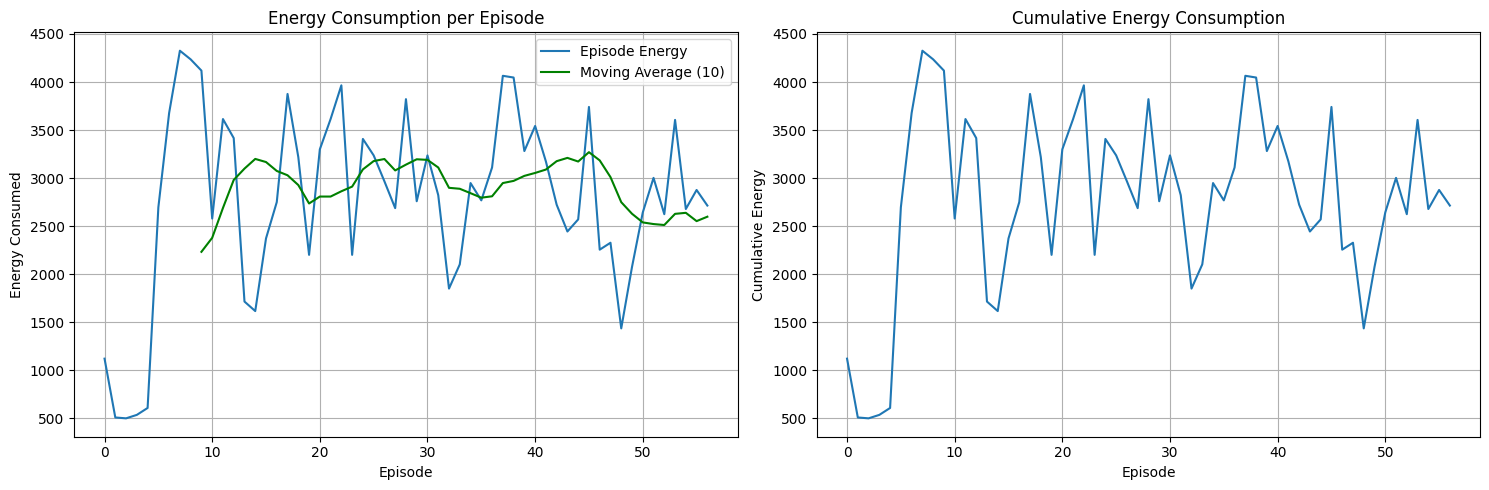

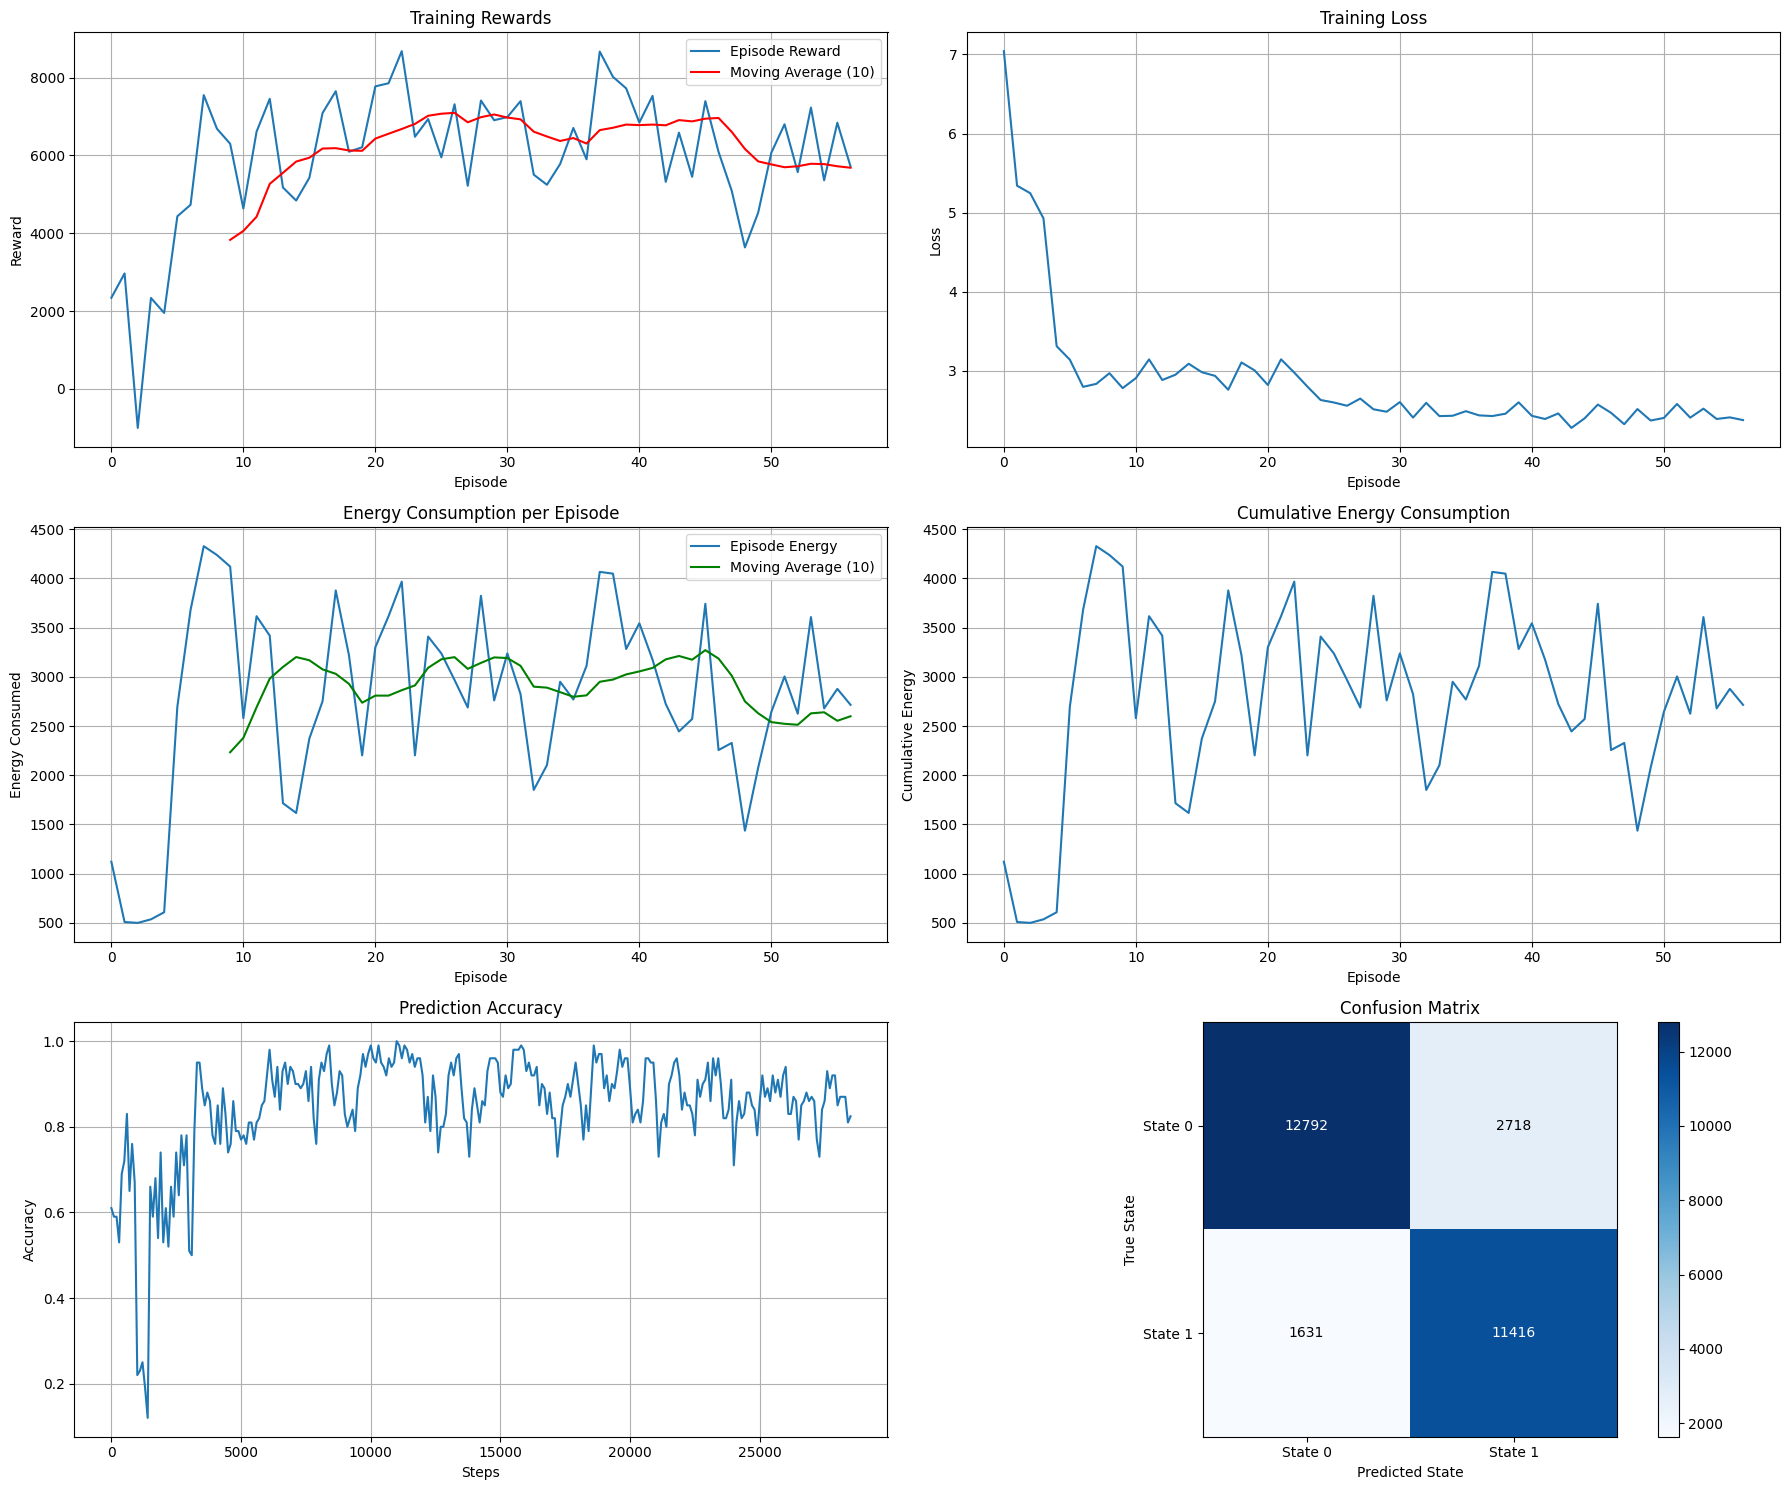

Final evaluation - Average reward over 20 episodes: 4176.75
Final evaluation - Average energy consumption over 20 episodes: 0.00
Reward-to-Energy Efficiency: 4176750.0000

Evaluating on test environment...
Test episode 10/10 completed. Reward: 4005.00

Test Results Summary:
Average reward: 4321.50
Prediction accuracy: 0.9084


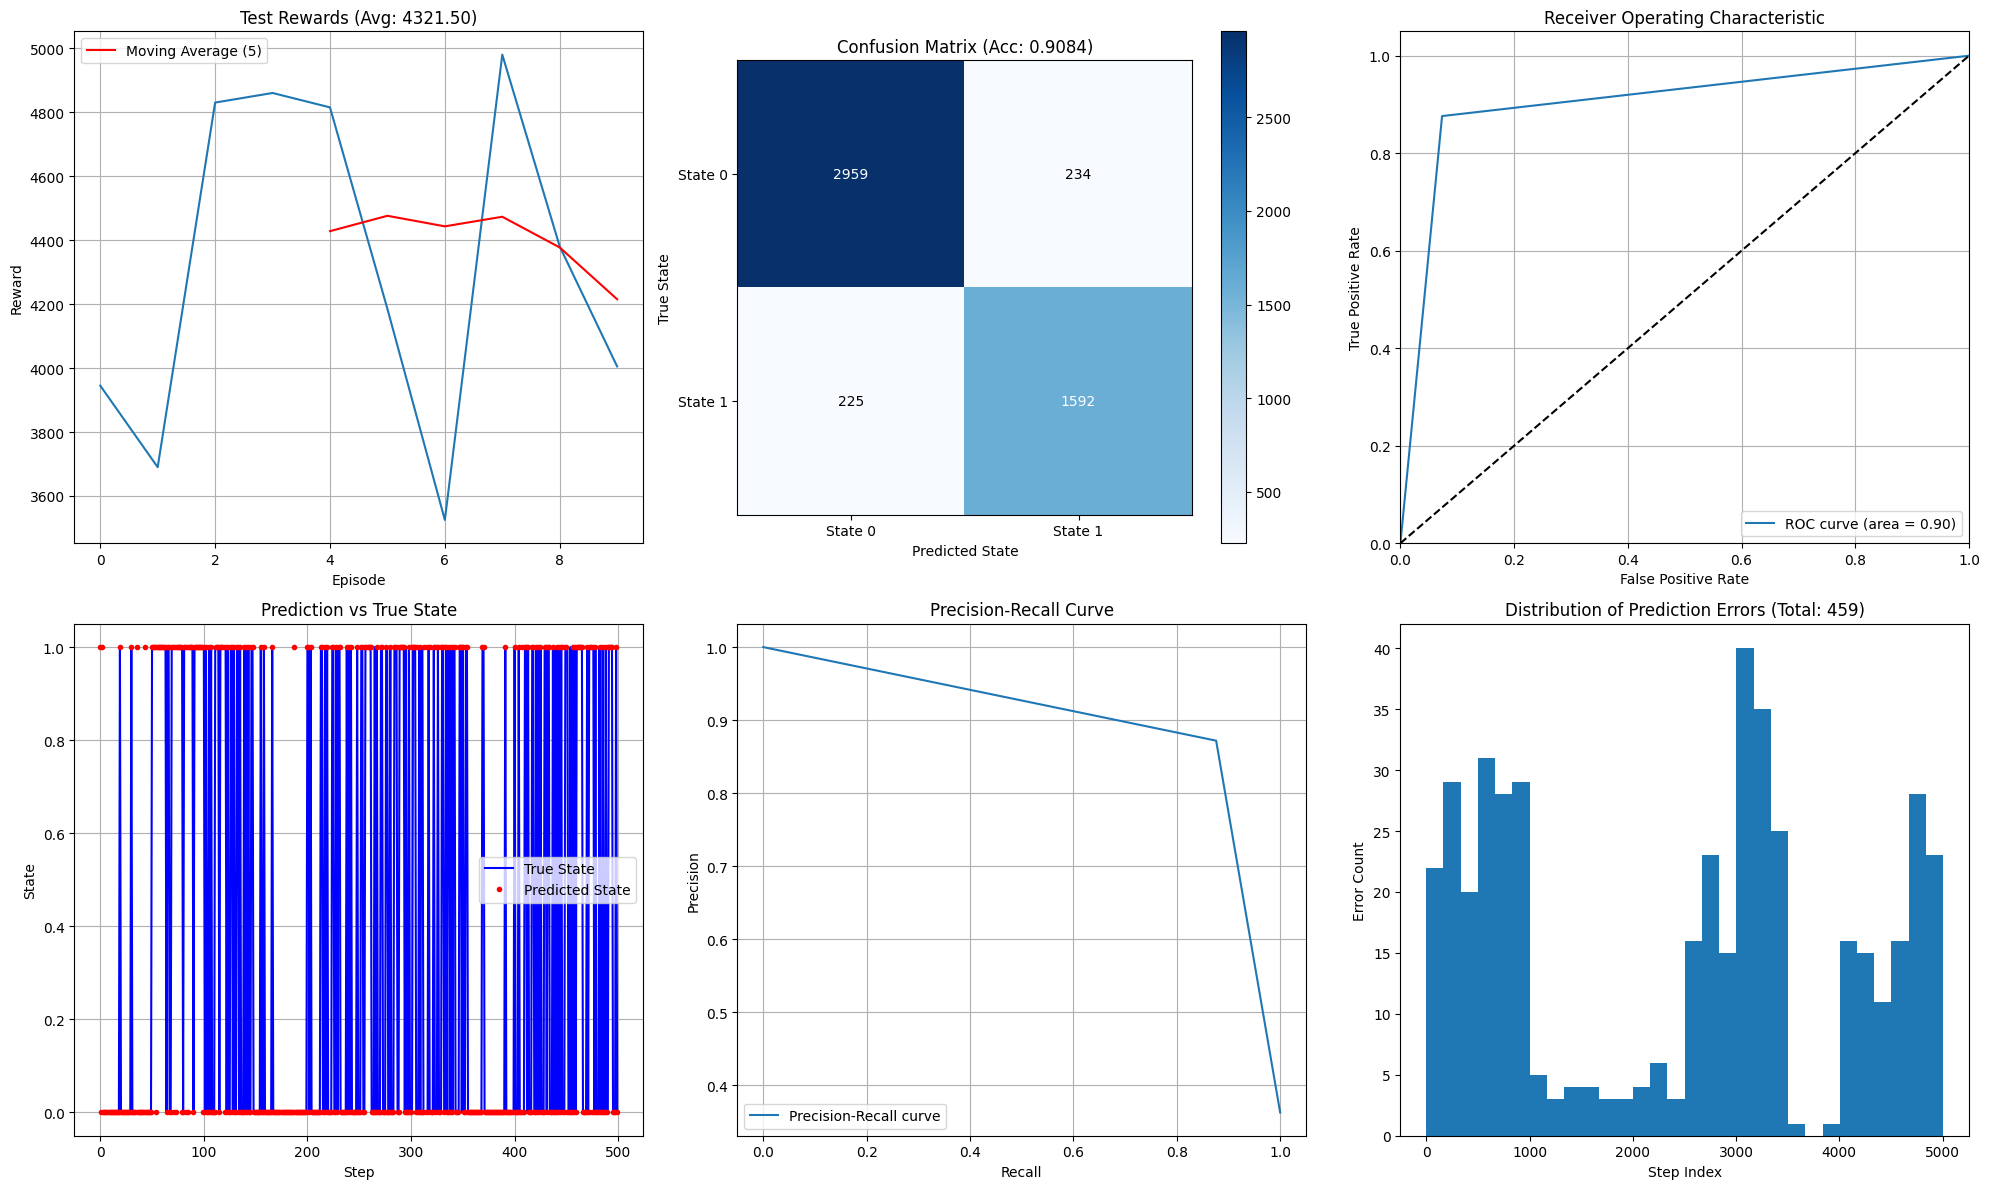

KeyError: 'predictions'

In [3]:
time_dependence = 1
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=10)

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_32222/2777551727.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_32222/2777551727.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:12<10:03,  1.23s/it]

Episode: 10, Reward: 4245.00, Avg Reward (last 10): 2478.00, Accuracy: 0.8982, Loss: 2.614562, Epsilon: 0.0100
New best model saved! Avg reward: 2478.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:13<10:09,  1.25s/it]

New best model saved! Avg reward: 2683.50


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:14<10:17,  1.27s/it]

New best model saved! Avg reward: 3076.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:15<10:17,  1.27s/it]

New best model saved! Avg reward: 3291.00


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:17<10:22,  1.28s/it]

New best model saved! Avg reward: 3556.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:18<10:13,  1.26s/it]

New best model saved! Avg reward: 3850.50


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:19<10:15,  1.27s/it]

New best model saved! Avg reward: 4035.00


Training Enhanced LSTM-DQN:   3%|▎         | 17/500 [00:21<10:19,  1.28s/it]

New best model saved! Avg reward: 4039.50


Training Enhanced LSTM-DQN:   4%|▎         | 18/500 [00:22<10:21,  1.29s/it]

New best model saved! Avg reward: 4132.50


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:23<10:12,  1.27s/it]

New best model saved! Avg reward: 4215.00
Episode: 20, Reward: 4020.00, Avg Reward (last 10): 4192.50, Accuracy: 0.8683, Loss: 2.798762, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:25<11:29,  1.44s/it]

Evaluation at episode 20: Reward = 3930.00


Training Enhanced LSTM-DQN:   4%|▍         | 21/500 [00:26<11:10,  1.40s/it]

New best model saved! Avg reward: 4236.00


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:28<10:58,  1.38s/it]

New best model saved! Avg reward: 4249.50


Training Enhanced LSTM-DQN:   5%|▌         | 25/500 [00:32<10:47,  1.36s/it]

New best model saved! Avg reward: 4338.00


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:38<10:13,  1.30s/it]

Episode: 30, Reward: 4560.00, Avg Reward (last 10): 4083.00, Accuracy: 0.9401, Loss: 2.580724, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:50<10:21,  1.35s/it]

Episode: 40, Reward: 4605.00, Avg Reward (last 10): 4293.00, Accuracy: 0.9461, Loss: 2.358913, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:52<11:31,  1.50s/it]

Evaluation at episode 40: Reward = 3810.00


Training Enhanced LSTM-DQN:   8%|▊         | 41/500 [00:54<11:13,  1.47s/it]

New best model saved! Avg reward: 4366.50


Training Enhanced LSTM-DQN:   8%|▊         | 42/500 [00:55<11:01,  1.44s/it]

New best model saved! Avg reward: 4432.50


Training Enhanced LSTM-DQN:   9%|▊         | 43/500 [00:56<10:48,  1.42s/it]

New best model saved! Avg reward: 4444.50


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:06<10:19,  1.38s/it]

Episode: 50, Reward: 4035.00, Avg Reward (last 10): 4303.50, Accuracy: 0.8703, Loss: 2.326992, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 59/500 [01:19<10:19,  1.40s/it]

Episode: 60, Reward: 4170.00, Avg Reward (last 10): 4141.50, Accuracy: 0.8882, Loss: 2.290561, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  12%|█▏        | 60/500 [01:21<11:22,  1.55s/it]

Evaluation at episode 60: Reward = 3645.00


Training Enhanced LSTM-DQN:  14%|█▍        | 70/500 [01:35<10:30,  1.47s/it]

Episode: 70, Reward: 4845.00, Avg Reward (last 10): 4200.00, Accuracy: 0.9780, Loss: 2.322737, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  14%|█▍        | 72/500 [01:40<09:55,  1.39s/it]

Early stopping after 73 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8620


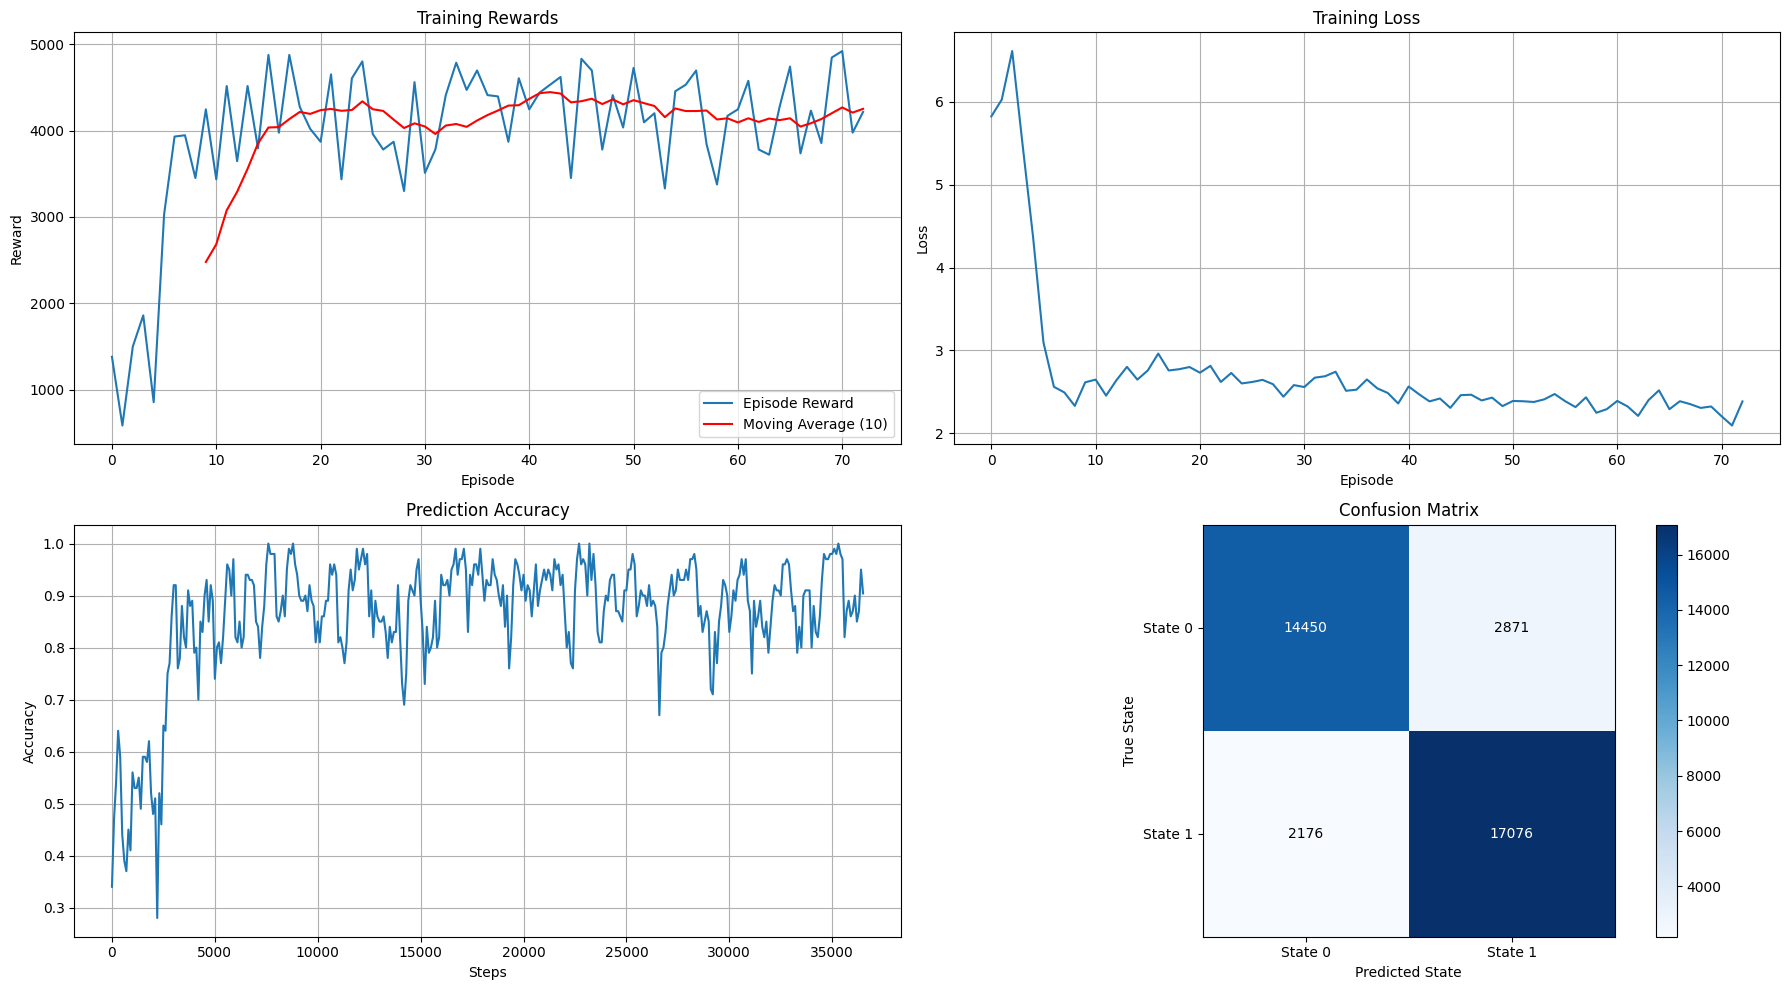


Evaluating on test environment...
Test episode 10/100 completed. Reward: 4695.00
Test episode 20/100 completed. Reward: 4755.00
Test episode 30/100 completed. Reward: 4005.00
Test episode 40/100 completed. Reward: 3720.00
Test episode 50/100 completed. Reward: 4410.00
Test episode 60/100 completed. Reward: 3915.00
Test episode 70/100 completed. Reward: 4260.00
Test episode 80/100 completed. Reward: 3630.00
Test episode 90/100 completed. Reward: 4005.00
Test episode 100/100 completed. Reward: 4725.00

Test Results Summary:
Average reward: 4185.90
Prediction accuracy: 0.8903


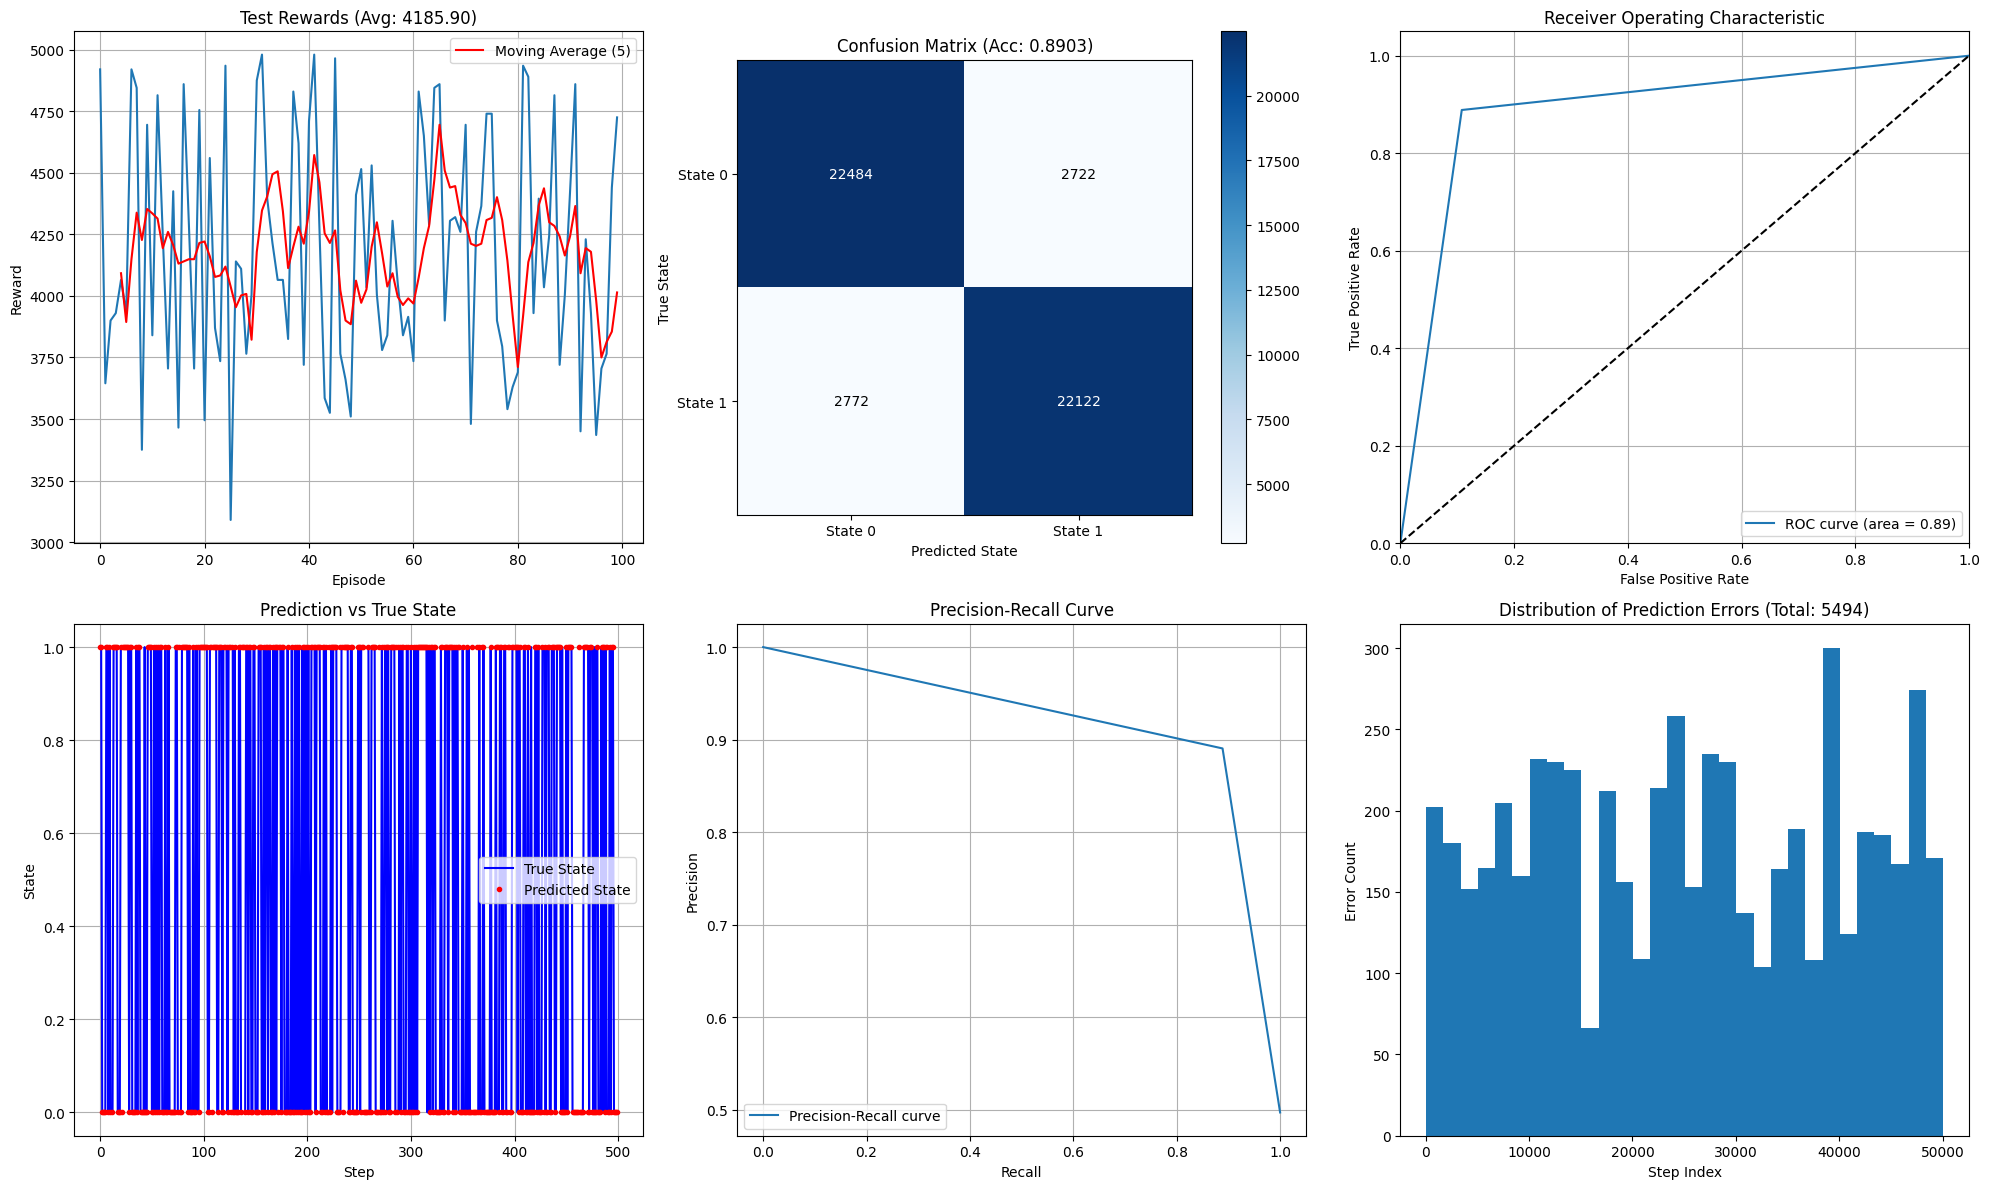


Training vs Test Performance:
Training accuracy: 0.8620
Test accuracy: 0.8903
Accuracy difference: 0.0283
Model generalizes well to the test environment.


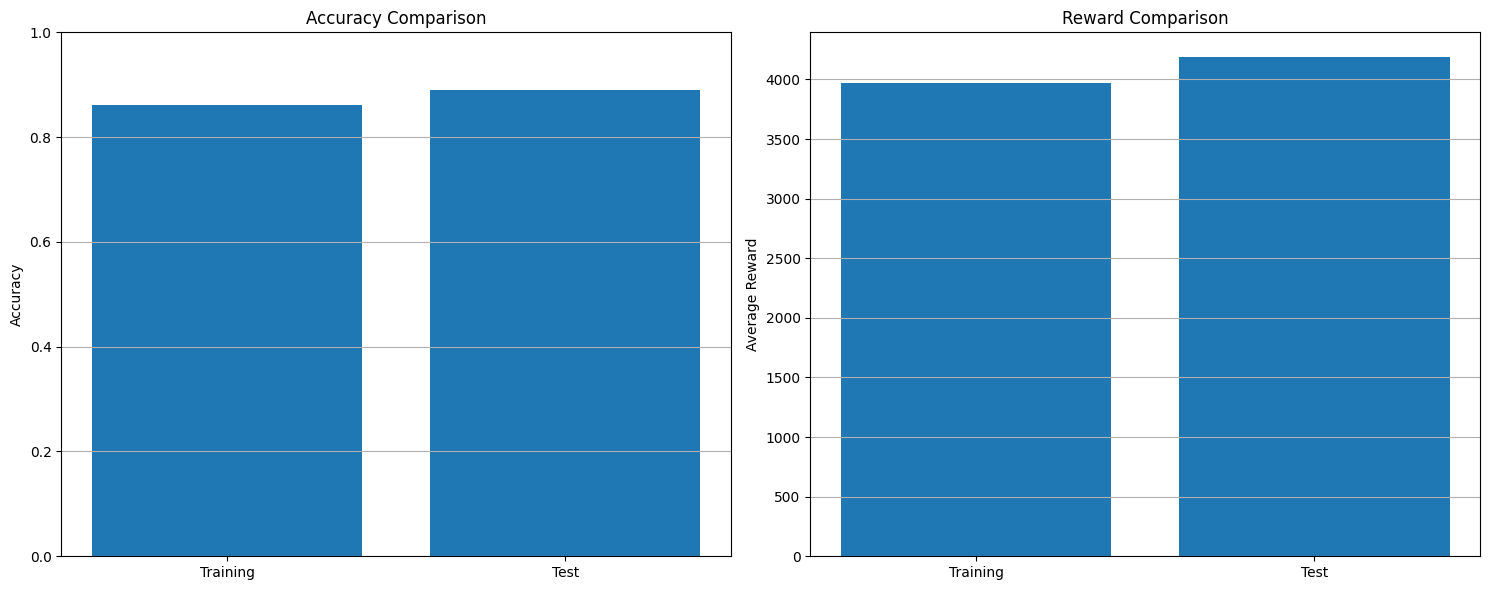

Experiment with separate testing completed!


In [ ]:
time_dependence = 2
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_32222/2777551727.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_32222/2777551727.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:11<09:52,  1.21s/it]

Episode: 10, Reward: 3750.00, Avg Reward (last 10): 2964.00, Accuracy: 0.8323, Loss: 2.881958, Epsilon: 0.0100
New best model saved! Avg reward: 2964.00


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:13<09:54,  1.22s/it]

New best model saved! Avg reward: 3258.00


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:14<09:49,  1.21s/it]

New best model saved! Avg reward: 3562.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:15<09:47,  1.21s/it]

New best model saved! Avg reward: 3786.00


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:16<09:47,  1.21s/it]

New best model saved! Avg reward: 4009.50


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:17<09:46,  1.21s/it]

New best model saved! Avg reward: 4147.50


Training Enhanced LSTM-DQN:   3%|▎         | 17/500 [00:20<09:48,  1.22s/it]

New best model saved! Avg reward: 4177.50


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:22<09:54,  1.24s/it]

Episode: 20, Reward: 3855.00, Avg Reward (last 10): 4005.00, Accuracy: 0.8463, Loss: 2.868179, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:24<11:03,  1.38s/it]

Evaluation at episode 20: Reward = 4260.00


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:37<10:12,  1.30s/it]

Episode: 30, Reward: 3870.00, Avg Reward (last 10): 4165.50, Accuracy: 0.8483, Loss: 2.612248, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:50<11:19,  1.47s/it]

Episode: 40, Reward: 4095.00, Avg Reward (last 10): 4065.00, Accuracy: 0.8782, Loss: 2.632043, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:52<12:46,  1.67s/it]

Evaluation at episode 40: Reward = 4725.00


Training Enhanced LSTM-DQN:   9%|▉         | 46/500 [01:03<10:24,  1.38s/it]

Early stopping after 47 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8385


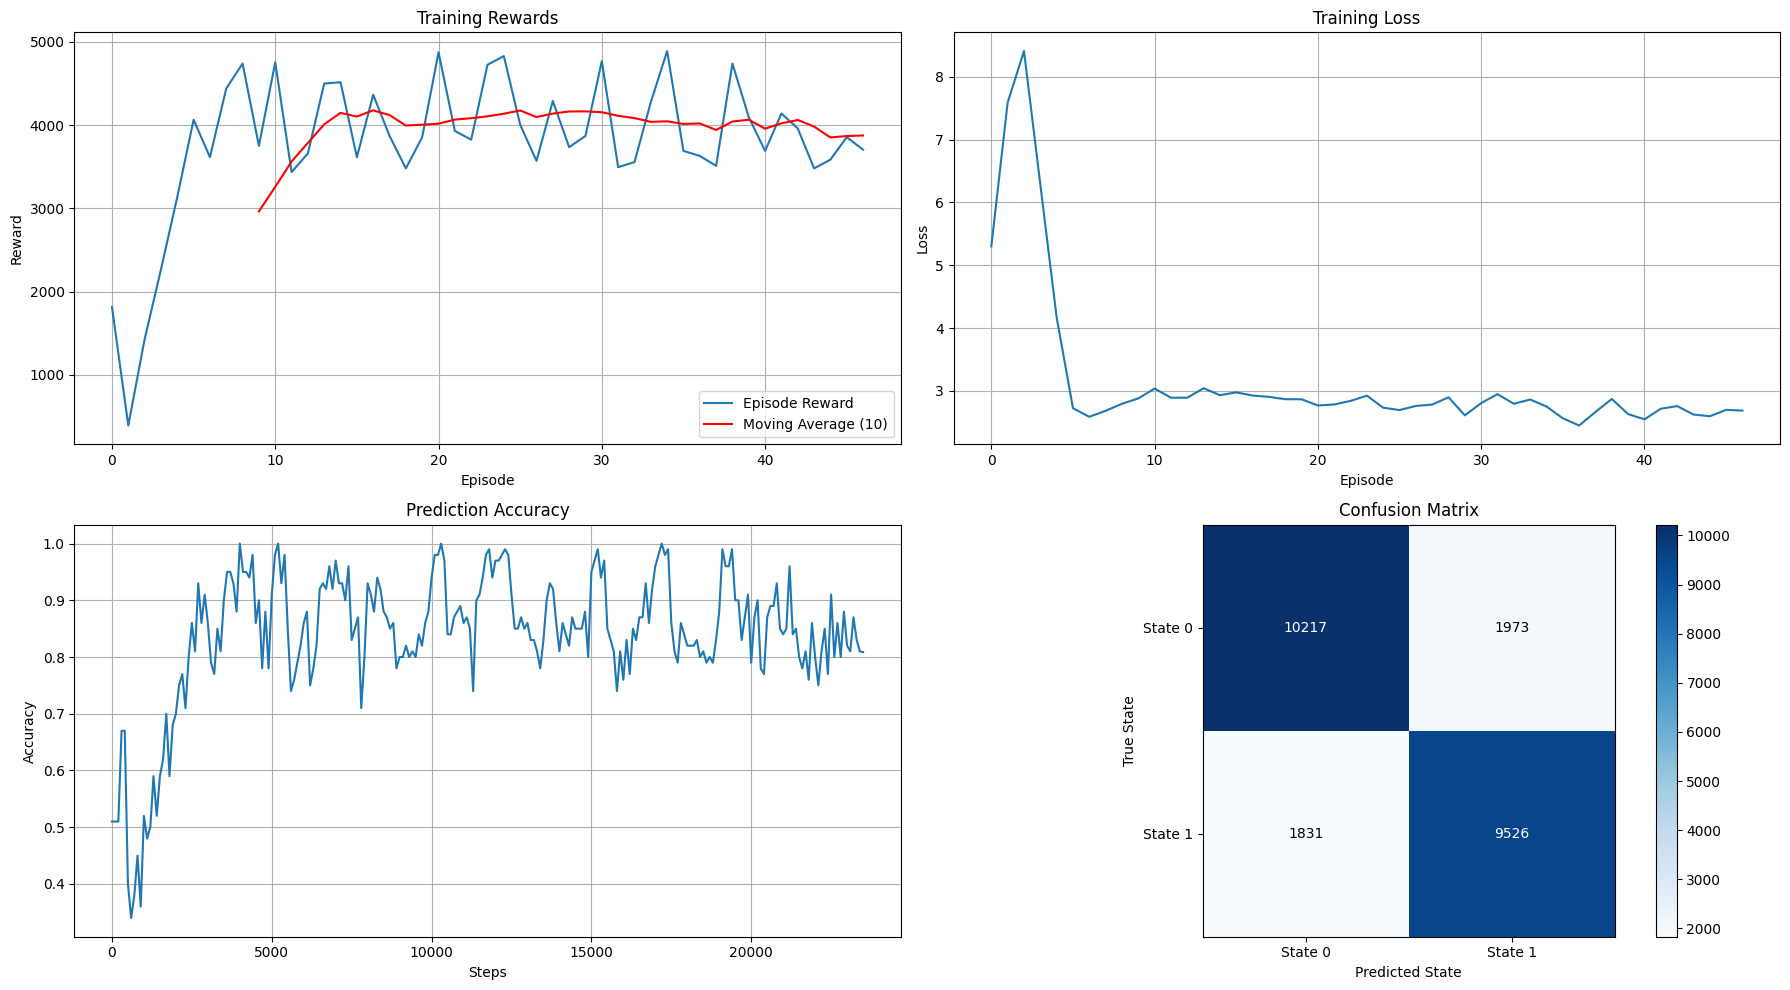


Evaluating on test environment...
Test episode 10/100 completed. Reward: 4395.00
Test episode 20/100 completed. Reward: 4695.00
Test episode 30/100 completed. Reward: 3810.00
Test episode 40/100 completed. Reward: 4905.00
Test episode 50/100 completed. Reward: 4380.00
Test episode 60/100 completed. Reward: 4170.00
Test episode 70/100 completed. Reward: 3795.00
Test episode 80/100 completed. Reward: 3870.00
Test episode 90/100 completed. Reward: 4395.00
Test episode 100/100 completed. Reward: 4035.00

Test Results Summary:
Average reward: 4225.80
Prediction accuracy: 0.8956


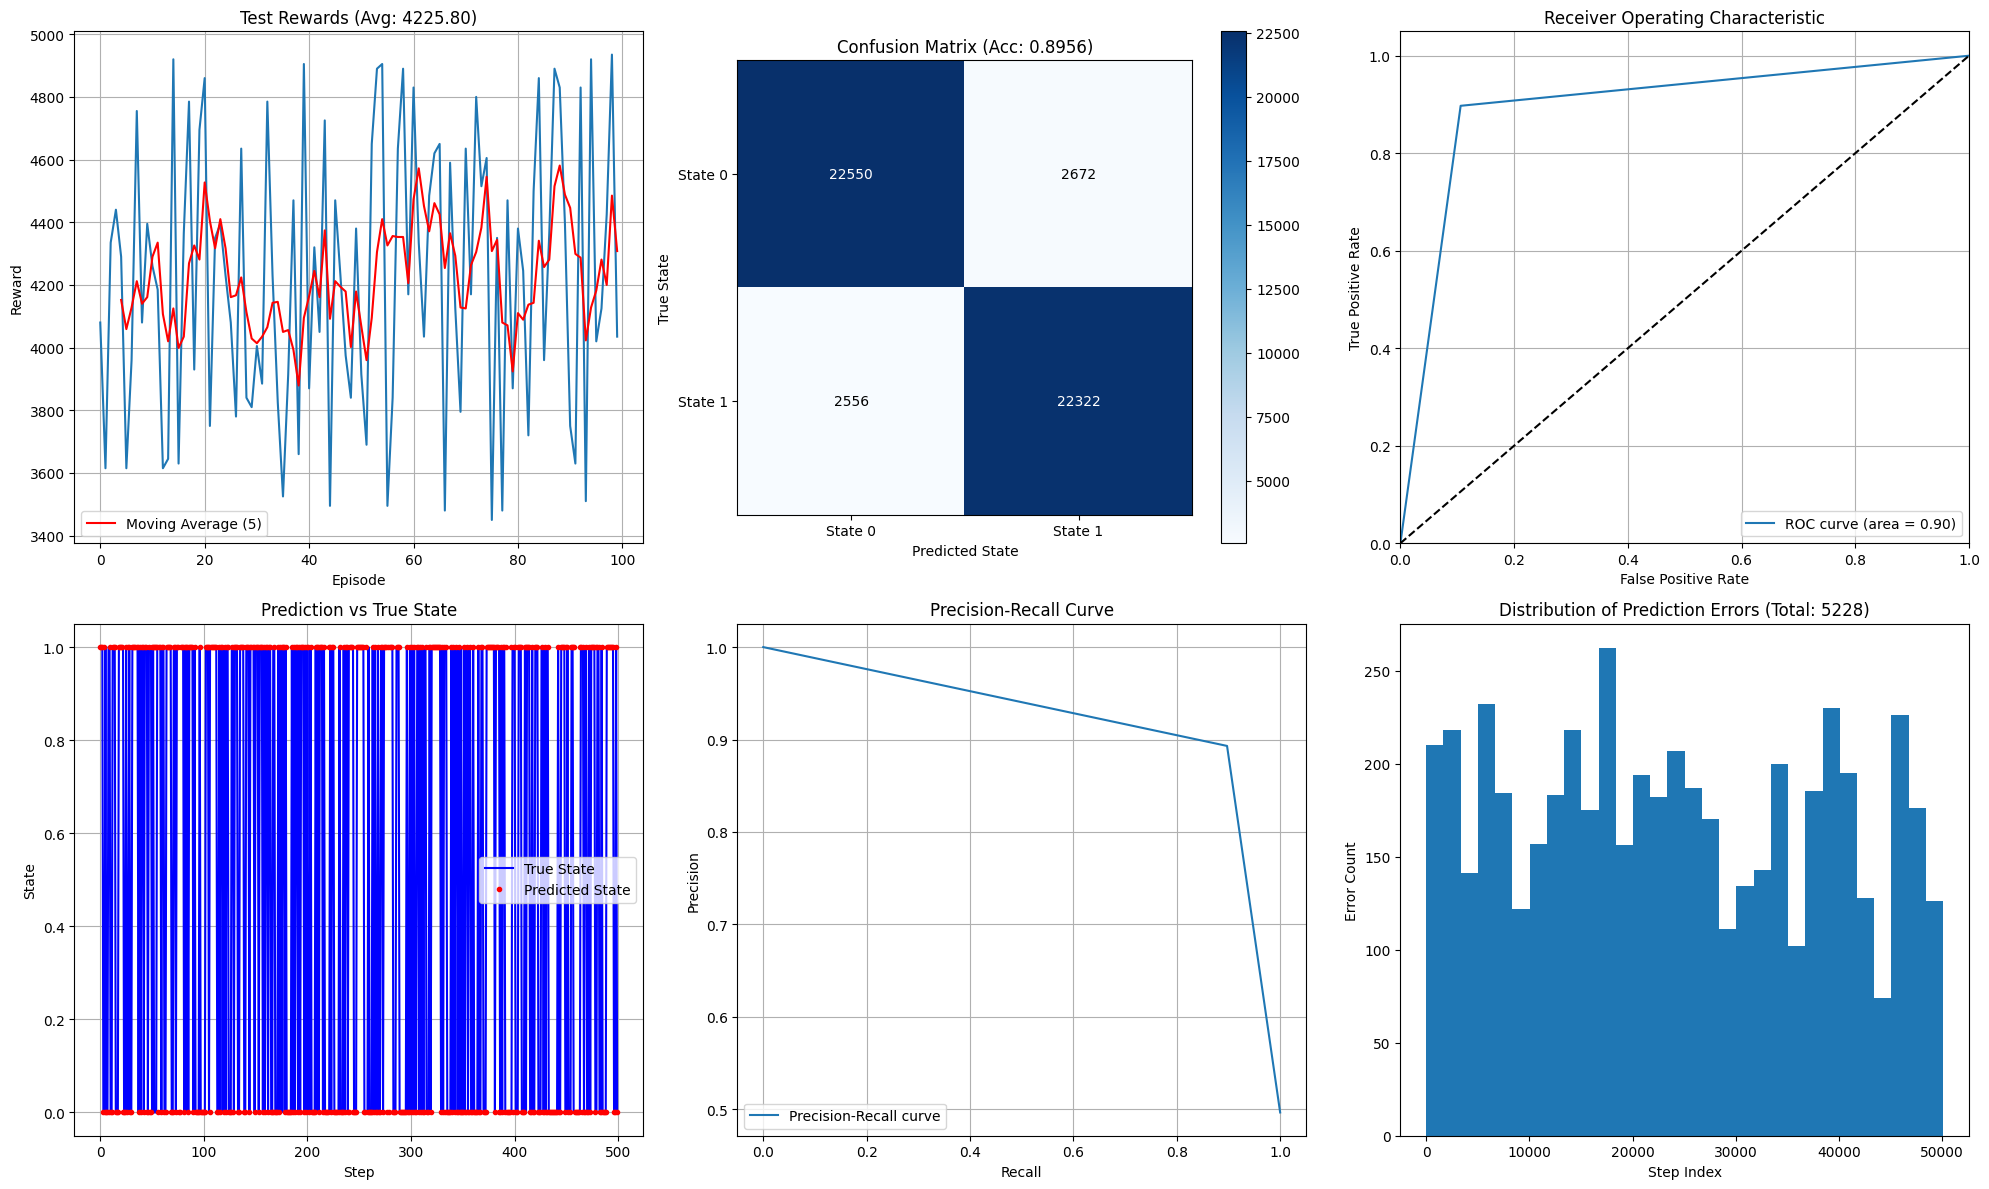


Training vs Test Performance:
Training accuracy: 0.8385
Test accuracy: 0.8956
Accuracy difference: 0.0572
Model generalizes well to the test environment.


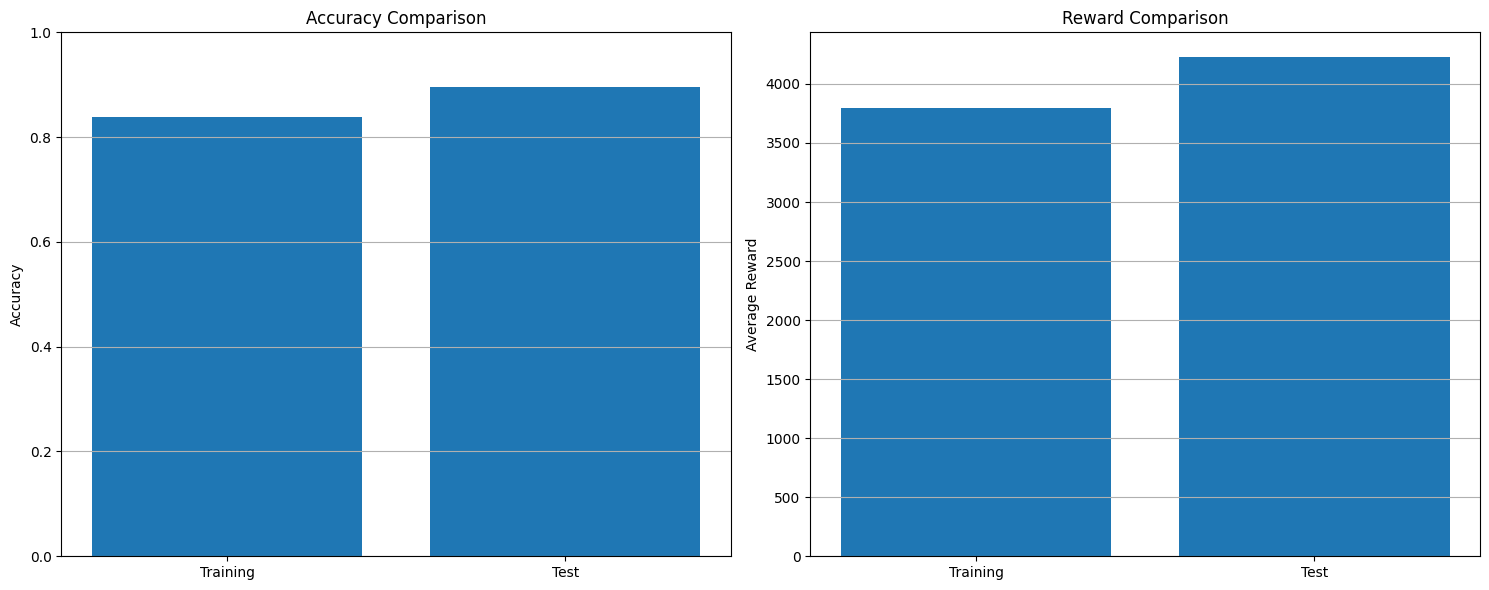

Experiment with separate testing completed!


In [ ]:
time_dependence = 3
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

Training Enhanced LSTM-DQN:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_32222/2777551727.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
/tmp/ipykernel_32222/2777551727.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced LSTM-DQN:   2%|▏         | 10/500 [00:13<11:11,  1.37s/it]

Episode: 10, Reward: 4290.00, Avg Reward (last 10): 2938.50, Accuracy: 0.9042, Loss: 2.972314, Epsilon: 0.0100
New best model saved! Avg reward: 2938.50


Training Enhanced LSTM-DQN:   2%|▏         | 11/500 [00:14<11:10,  1.37s/it]

New best model saved! Avg reward: 3264.00


Training Enhanced LSTM-DQN:   2%|▏         | 12/500 [00:16<11:10,  1.37s/it]

New best model saved! Avg reward: 3469.50


Training Enhanced LSTM-DQN:   3%|▎         | 13/500 [00:17<11:10,  1.38s/it]

New best model saved! Avg reward: 3808.50


Training Enhanced LSTM-DQN:   3%|▎         | 14/500 [00:19<11:06,  1.37s/it]

New best model saved! Avg reward: 4077.00


Training Enhanced LSTM-DQN:   3%|▎         | 15/500 [00:20<11:09,  1.38s/it]

New best model saved! Avg reward: 4137.00


Training Enhanced LSTM-DQN:   3%|▎         | 16/500 [00:21<11:13,  1.39s/it]

New best model saved! Avg reward: 4141.50


Training Enhanced LSTM-DQN:   4%|▍         | 19/500 [00:26<11:19,  1.41s/it]

New best model saved! Avg reward: 4144.50
Episode: 20, Reward: 4635.00, Avg Reward (last 10): 4179.00, Accuracy: 0.9501, Loss: 2.572476, Epsilon: 0.0100
New best model saved! Avg reward: 4179.00


Training Enhanced LSTM-DQN:   4%|▍         | 20/500 [00:28<12:36,  1.58s/it]

Evaluation at episode 20: Reward = 4455.00


Training Enhanced LSTM-DQN:   4%|▍         | 22/500 [00:30<11:56,  1.50s/it]

New best model saved! Avg reward: 4273.50


Training Enhanced LSTM-DQN:   5%|▍         | 23/500 [00:32<11:40,  1.47s/it]

New best model saved! Avg reward: 4297.50


Training Enhanced LSTM-DQN:   5%|▌         | 26/500 [00:36<11:28,  1.45s/it]

New best model saved! Avg reward: 4299.00


Training Enhanced LSTM-DQN:   5%|▌         | 27/500 [00:38<11:23,  1.45s/it]

New best model saved! Avg reward: 4353.00


Training Enhanced LSTM-DQN:   6%|▌         | 28/500 [00:39<11:20,  1.44s/it]

New best model saved! Avg reward: 4359.00


Training Enhanced LSTM-DQN:   6%|▌         | 30/500 [00:42<11:16,  1.44s/it]

Episode: 30, Reward: 3540.00, Avg Reward (last 10): 4174.50, Accuracy: 0.8044, Loss: 2.604969, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 39/500 [00:54<10:29,  1.37s/it]

Episode: 40, Reward: 4770.00, Avg Reward (last 10): 4146.00, Accuracy: 0.9681, Loss: 2.431217, Epsilon: 0.0100


Training Enhanced LSTM-DQN:   8%|▊         | 40/500 [00:56<11:37,  1.52s/it]

Evaluation at episode 40: Reward = 4830.00


Training Enhanced LSTM-DQN:  10%|█         | 50/500 [01:10<10:12,  1.36s/it]

Episode: 50, Reward: 3510.00, Avg Reward (last 10): 4020.00, Accuracy: 0.8004, Loss: 2.520177, Epsilon: 0.0100


Training Enhanced LSTM-DQN:  11%|█▏        | 57/500 [01:21<10:34,  1.43s/it]

Early stopping after 58 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8573


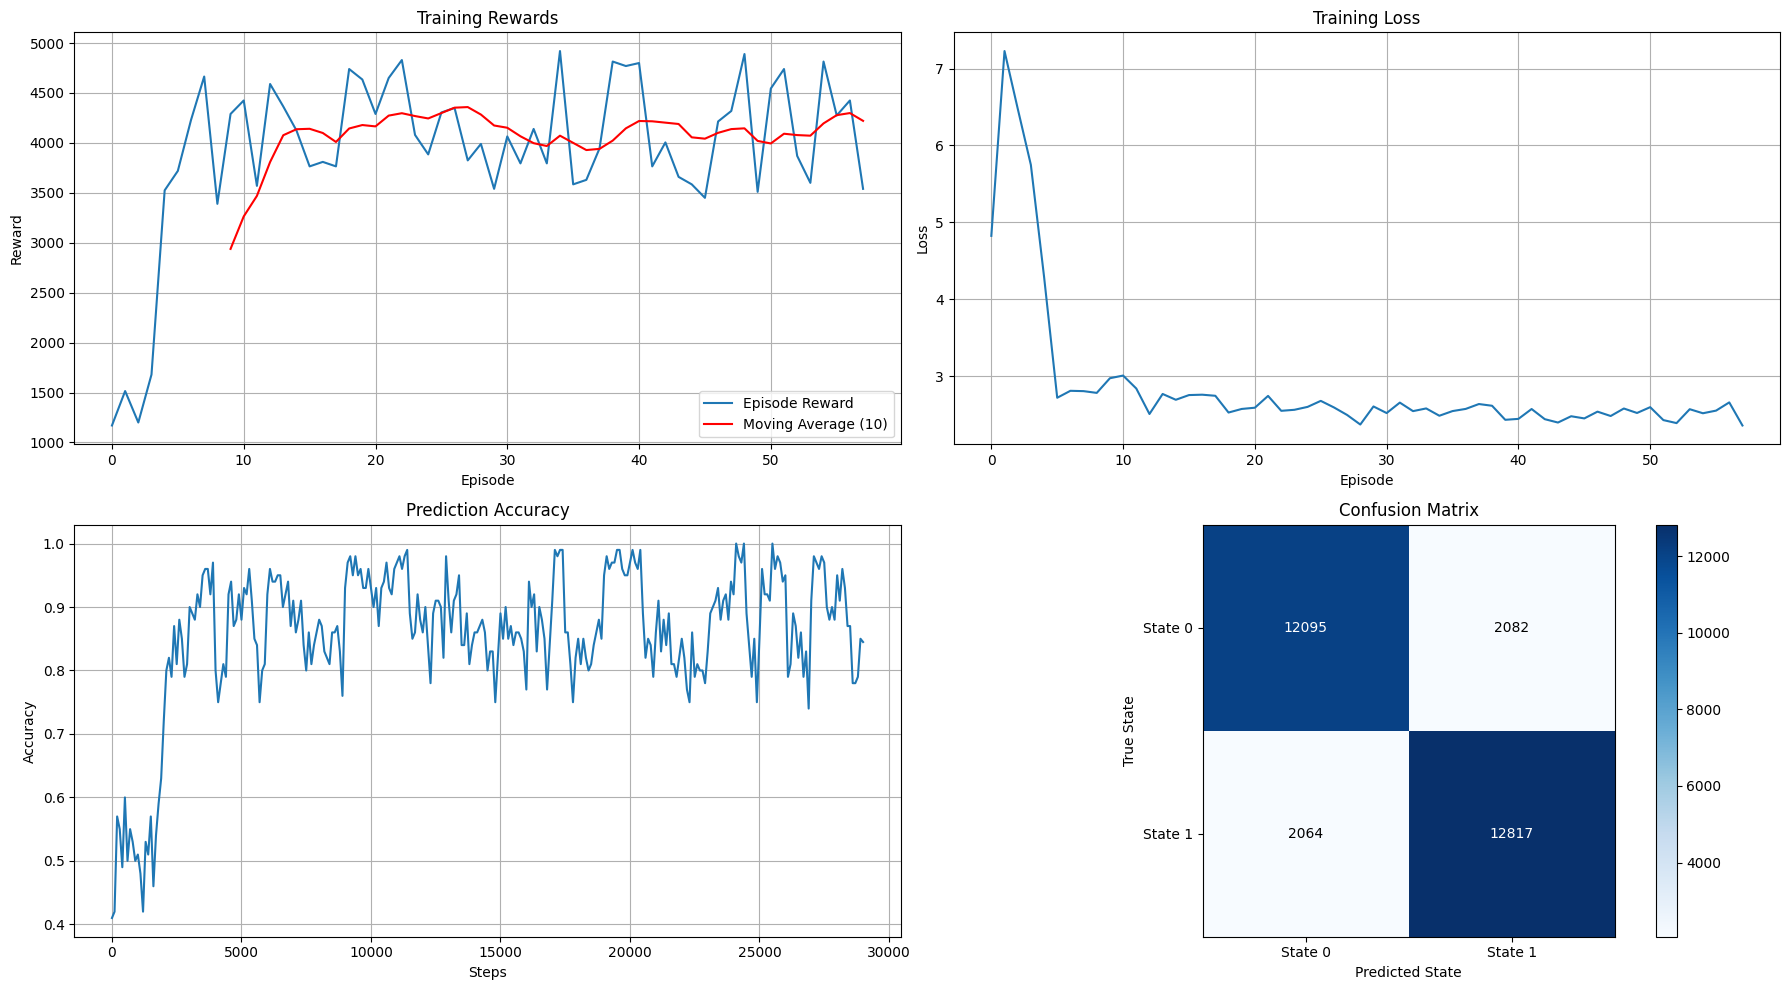


Evaluating on test environment...
Test episode 10/100 completed. Reward: 3840.00
Test episode 20/100 completed. Reward: 3735.00


In [ ]:
time_dependence = 4
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from collections import deque
import copy
import matplotlib.cm as cm

def train_multi_band_with_energy_tracking(env, agent, episodes=500, eval_freq=10):
    """Train the enhanced DQN agent with energy tracking for multi-band environment"""
    # Record best model for early stopping
    best_reward = float('-inf')
    best_model = None
    no_improvement_count = 0
    
    # Training metrics
    episode_rewards = []
    all_predictions = []
    all_true_states = []
    training_losses = []
    
    # Energy metrics
    episode_energy_costs = []
    transition_costs = []  # Track band transition costs
    base_energy_costs = []  # Track base action energy costs
    all_energy_costs = []
    cumulative_energy = []
    total_energy_spent = 0
    
    # Band selection tracking
    band_selections = []
    
    # Episode window for tracking improvement
    window_size = 10
    window_rewards = deque(maxlen=window_size)
    
    # Training loop
    for episode in tqdm(range(episodes), desc="Training Multi-Band DQN"):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        episode_energy = 0
        episode_transition_cost = 0
        episode_base_energy = 0
        steps = 0
        done = False
        
        # Clear LSTM hidden state at episode start
        agent.hidden = None
        
        # Episode experience collection
        episode_predictions = []
        episode_true_states = []
        episode_bands = []
        
        while not done:
            # Select action
            action, agent.hidden = agent.select_action(state, hidden=agent.hidden)
            
            # Execute action
            next_state, reward, done, info = env.step(action)
            
            # Record energy costs
            energy_cost = info.get("energy_cost", 0)
            transition_cost = info.get("transition_cost", 0)
            base_energy = energy_cost - transition_cost
            
            episode_energy += energy_cost
            episode_transition_cost += transition_cost
            episode_base_energy += base_energy
            
            all_energy_costs.append(energy_cost)
            
            # Record band selection
            selected_band = info.get("selected_band", 0)
            episode_bands.append(selected_band)
            
            # Record prediction and true state
            base_action = action % 4  # For multi-band, base action is modulo 4
            episode_predictions.append(base_action % 2)  # Get 0 or 1 prediction
            episode_true_states.append(info["actual_state"])
            
            # Remember in replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Update state
            state = next_state
                
            episode_reward += reward
            steps += 1
            
            # Train the network more frequently for faster learning
            if steps % 4 == 0:
                loss = agent.replay()
                if loss is not None:
                    episode_loss += loss
            
            # Update epsilon for backup exploration
            agent.update_epsilon()
        
        # Additional training at end of episode (multiple updates)
        for _ in range(4):
            loss = agent.replay()
            if loss is not None:
                episode_loss += loss
        
        # Update target network
        agent.update_target_network()
        
        # Record episode metrics
        avg_loss = episode_loss / max(1, steps // 4)
        episode_rewards.append(episode_reward)
        all_predictions.extend(episode_predictions)
        all_true_states.extend(episode_true_states)
        training_losses.append(avg_loss)
        window_rewards.append(episode_reward)
        
        # Update energy metrics
        episode_energy_costs.append(episode_energy)
        transition_costs.append(episode_transition_cost)
        base_energy_costs.append(episode_base_energy)
        total_energy_spent += episode_energy
        cumulative_energy.append(total_energy_spent)
        
        # Record band selection stats
        band_selections.append(pd.Series(episode_bands).value_counts(normalize=True).to_dict())
        
        # Calculate accuracy for the episode
        episode_accuracy = np.mean(np.array(episode_predictions) == np.array(episode_true_states))
        
        # Print progress
        if (episode + 1) % 10 == 0:
            window_avg = np.mean(window_rewards)
            print(f"Episode: {episode+1}, Reward: {episode_reward:.2f}, Avg Reward (last {window_size}): {window_avg:.2f}, "
                  f"Energy: {episode_energy:.2f} (Base: {episode_base_energy:.2f}, Trans: {episode_transition_cost:.2f}), "
                  f"Accuracy: {episode_accuracy:.4f}, Loss: {avg_loss:.6f}")
            
            # Update learning rate based on performance
            agent.scheduler.step(window_avg)
        
        # Save best model
        if len(window_rewards) == window_size:
            window_avg = np.mean(window_rewards)
            if window_avg > best_reward:
                best_reward = window_avg
                best_model = copy.deepcopy(agent.policy_net.state_dict())
                no_improvement_count = 0
                print(f"New best model saved! Avg reward: {best_reward:.2f}")
            else:
                no_improvement_count += 1
        
        # Early stopping if no improvement for a while
        if no_improvement_count >= 30:
            print(f"Early stopping after {episode+1} episodes - no improvement for 30 episodes")
            if best_model is not None:
                agent.policy_net.load_state_dict(best_model)
            break
                
        # Evaluate agent periodically
        if (episode + 1) % eval_freq == 0:
            eval_result = evaluate_multi_band_with_energy(env, agent)
            eval_reward, eval_energy, eval_bands = eval_result
            print(f"Evaluation at episode {episode+1}: Reward = {eval_reward:.2f}, Energy = {eval_energy:.2f}")
            band_dist = ", ".join([f"Band {i}: {count:.1%}" for i, count in eval_bands.items()])
            print(f"Band distribution: {band_dist}")
            
    # Update agent metrics
    agent.rewards_history = episode_rewards
    agent.losses = training_losses
    agent.predictions = all_predictions
    agent.true_states = all_true_states
    
    # Store energy metrics
    agent.episode_energy_costs = episode_energy_costs
    agent.transition_costs = transition_costs
    agent.base_energy_costs = base_energy_costs
    agent.all_energy_costs = all_energy_costs
    agent.cumulative_energy = cumulative_energy
    agent.band_selections = band_selections
    
    # If training completed without early stopping, load best model
    if best_model is not None and episode == episodes - 1:
        agent.policy_net.load_state_dict(best_model)
        
    # Calculate final accuracy
    final_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
    print(f"Training completed. Final accuracy: {final_accuracy:.4f}, Total energy spent: {total_energy_spent:.2f}")
    
    return agent, episode_rewards, training_losses, episode_energy_costs, cumulative_energy, transition_costs, base_energy_costs, band_selections


def evaluate_multi_band_with_energy(env, agent):
    """Evaluate the agent on a single episode without exploration and track energy and band selection"""
    state = env.reset()
    done = False
    total_reward = 0
    total_energy = 0
    hidden = None
    band_selections = []
    
    while not done:
        # Select action without exploration
        action, hidden = agent.select_action(state, evaluate=True, hidden=hidden)
        
        # Execute action
        next_state, reward, done, info = env.step(action)
        
        # Track energy cost
        energy_cost = info.get("energy_cost", 0)
        total_energy += energy_cost
        
        # Track band selection
        selected_band = info.get("selected_band", 0)
        band_selections.append(selected_band)
        
        total_reward += reward
        
        # Update state
        state = next_state
    
    # Calculate band distribution
    band_dist = pd.Series(band_selections).value_counts(normalize=True).to_dict()
    
    return total_reward, total_energy, band_dist


def plot_multi_band_results(rewards, losses, energy_costs, cumulative_energy, 
                           transition_costs, base_energy_costs, band_selections,
                           predictions=None, true_states=None, num_bands=3):
    """Plot training metrics and model performance including energy consumption for multi-band environment"""
    plt.figure(figsize=(20, 20))
    
    # Plot rewards
    plt.subplot(4, 2, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(pd.Series(rewards).rolling(10).mean(), 'r-', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot losses
    plt.subplot(4, 2, 2)
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # Plot energy breakdown
    plt.subplot(4, 2, 3)
    plt.plot(energy_costs, 'b-', label='Total Energy')
    plt.plot(base_energy_costs, 'g-', label='Base Action Energy')
    plt.plot(transition_costs, 'r-', label='Transition Energy')
    plt.plot(pd.Series(energy_costs).rolling(10).mean(), 'k--', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Energy Cost')
    plt.title('Energy Consumption Breakdown per Episode')
    plt.legend()
    plt.grid(True)
    
    # Plot cumulative energy
    plt.subplot(4, 2, 4)
    plt.plot(cumulative_energy)
    plt.xlabel('Episode')
    plt.ylabel('Total Energy')
    plt.title('Cumulative Energy Consumption')
    plt.grid(True)
    
    # Plot band selection over time
    plt.subplot(4, 2, 5)
    band_data = []
    for i in range(num_bands):
        band_values = [b.get(i, 0) for b in band_selections]
        band_data.append(band_values)
        plt.plot(band_values, label=f'Band {i}')
    
    plt.xlabel('Episode')
    plt.ylabel('Selection Frequency')
    plt.title('Band Selection Frequency over Time')
    plt.legend()
    plt.grid(True)
    
    # Plot band selection distribution (averaged over last 50 episodes)
    plt.subplot(4, 2, 6)
    recent_selections = band_selections[-50:] if len(band_selections) >= 50 else band_selections
    
    # Combine recent selections
    combined = {}
    for selection in recent_selections:
        for band, count in selection.items():
            if band not in combined:
                combined[band] = []
            combined[band].append(count)
    
    # Calculate averages
    avg_selections = {band: np.mean(values) for band, values in combined.items()}
    
    # Plot
    bands = sorted(avg_selections.keys())
    values = [avg_selections.get(band, 0) for band in bands]
    plt.bar(bands, values, color=cm.viridis(np.linspace(0, 1, len(bands))))
    plt.xlabel('Band')
    plt.ylabel('Average Selection Frequency')
    plt.title('Band Selection Distribution (Last 50 Episodes)')
    plt.xticks(bands)
    plt.grid(True, axis='y')
    
    # Plot energy efficiency (reward per energy unit)
    plt.subplot(4, 2, 7)
    energy_efficiency = [r / max(e, 0.1) for r, e in zip(rewards, energy_costs)]
    plt.plot(energy_efficiency)
    plt.plot(pd.Series(energy_efficiency).rolling(10).mean(), 'r-', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward / Energy Unit')
    plt.title('Energy Efficiency over Time')
    plt.grid(True)
    plt.legend()
    
    # Plot accuracy if predictions and true states are provided
    if predictions is not None and true_states is not None:
        plt.subplot(4, 2, 8)
        
        # Calculate accuracy over time
        window = 100
        accuracies = []
        for i in range(0, len(predictions), window):
            end = min(i + window, len(predictions))
            acc = np.mean(np.array(predictions[i:end]) == np.array(true_states[i:end]))
            accuracies.append(acc)
        
        plt.plot(range(0, len(predictions), window), accuracies)
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Prediction Accuracy')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def run_multi_band_experiment(seed=42, episodes=300, num_bands=3):
    """Run a complete experiment with the multi-band SBEOS environment and enhanced DQN agent with energy tracking"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create environment
    from environments import MultiBandSBEOS
    env = MultiBandSBEOS(num_bands=num_bands, max_timesteps=500, window_size=10, time_dependence=3)
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = num_bands * 4  # Each band has 4 possible actions
    
    # Create agent with enhanced features
    from environments import EnhancedDQNAgent  # Import from your module
    agent = EnhancedDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=50000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,
        learning_rate=0.0003,
        target_update_freq=5,
        double_dqn=True,
        prioritized_replay=True,
        n_step_return=3,
        use_soft_targets=True
    )
    
    # Train agent with energy tracking
    results = train_multi_band_with_energy_tracking(
        env, agent, episodes=episodes, eval_freq=20
    )
    trained_agent, rewards, losses, energy_costs, cumulative_energy, transition_costs, base_energy_costs, band_selections = results
    
    # Plot results with energy consumption
    plot_multi_band_results(
        rewards, losses, energy_costs, cumulative_energy, transition_costs, base_energy_costs, band_selections,
        predictions=trained_agent.predictions, 
        true_states=trained_agent.true_states,
        num_bands=num_bands
    )
    
    # Evaluate final performance
    eval_rewards = []
    eval_energies = []
    eval_band_dist = {}
    
    for _ in range(20):  # Run 20 evaluation episodes
        reward, energy, band_dist = evaluate_multi_band_with_energy(env, trained_agent)
        eval_rewards.append(reward)
        eval_energies.append(energy)
        
        # Combine band distributions
        for band, count in band_dist.items():
            if band not in eval_band_dist:
                eval_band_dist[band] = []
            eval_band_dist[band].append(count)
    
    # Average the results
    avg_reward = np.mean(eval_rewards)
    avg_energy = np.mean(eval_energies)
    avg_band_dist = {band: np.mean(values) for band, values in eval_band_dist.items()}
    
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    print(f"Final evaluation - Average energy consumption over 20 episodes: {avg_energy:.2f}")
    
    band_dist_str = ", ".join([f"Band {i}: {count:.1%}" for i, count in sorted(avg_band_dist.items())])
    print(f"Final evaluation - Band distribution: {band_dist_str}")
    
    # Save the trained model
    trained_agent.save_model(f"multi_band_dqn_model_{num_bands}_bands.pt")
    
    return trained_agent